**Title:** Personalized Recommender System for Climate Investment Opportunities

**Objective:**

Create a recommender system that suggests climate-related investment opportunities to potential investors based on their historical investment behaviors, macroeconomic indicators, and climate data. The goal is to help investors discover suitable fundraising projects in the clean energy sector that align with their preferences and the socio-economic and environmental profiles of different countries.

**Description:**

The recommender system will leverage multiple datasets to provide personalized investment recommendations:

- **Investor Data:** Historical investment behaviors from `climate_fundraisers_df`, including the amount raised, technology sector, and country.
- **Macroeconomic Indicators:** Data such as Gross National Income per capita, GDP, and happiness index to represent the economic and social environment of each country.
- **Climate Data:** Information on greenhouse gas emissions, renewable energy consumption, and CO₂ emissions per capita to assess the environmental impact and focus of each country.

By integrating these datasets, the system will employ collaborative filtering and content-based filtering techniques to recommend investment opportunities that match investors' preferences and align with favorable macroeconomic and environmental conditions.

**Alignment with Course Content:**

- **Week 3/4/5:** Utilizes recommender systems concepts like collaborative filtering and latent factor models.
- **Week 7/8:** Incorporates content and structure in recommender systems by using contextual features such as country indicators and sector information.
- **Week 9:** Potentially models temporal dynamics if time-series data is considered for capturing trends in investments.

**Datasets to be Used:**

1. **Climate Fundraisers Data (`climate_fundraisers_df`):**
   - **Features:** `fundraising_entity`, `amount_raised`, `normalized_amount_raised`, `clean_technology_sector`, `country`, `date_of_funding_reported`, etc.
   - **Usage:** Provides the core data on fundraising events and investor behaviors.

2. **Gross National Income per Capita (`gross-national-income-per-capita-undp.csv`):**
   - **Features:** `Entity` (Country), `Year`, `Gross national income per capita`.
   - **Usage:** Represents the economic prosperity of each country.

3. **Happiness Index (`happiness-cantril-ladder.csv`):**
   - **Features:** `Entity` (Country), `Year`, `Cantril ladder score`.
   - **Usage:** Indicates social well-being, potentially affecting investment attractiveness.

4. **Renewable Energy Share (`renewable-share-energy.csv`):**
   - **Features:** `Entity` (Country), `Year`, `Renewables (% equivalent primary energy)`.
   - **Usage:** Shows a country's commitment to renewable energy, aligning with investor interests in clean technology.

5. **Total Greenhouse Gas Emissions per Capita (`total-greenhouse-gas-emissions-per-capita.csv`):**
   - **Features:** `Entity` (Country), `Year`, `Total greenhouse gas emissions per capita including land-use change and forestry`.
   - **Usage:** Provides environmental impact data to assess the sustainability focus of countries.

6. **Average Monthly Surface Temperature (`average-monthly-surface-temperature.csv`):**
   - **Features:** `Entity` (Country), `Year`, `Day`, `Average surface temperature`.
   - **Usage:** Used to calculate temperature anomalies, reflecting climate changes over time.

7. **Monthly Temperature Anomalies (`monthly-temperature-anomalies.csv`):**
   - **Features:** `Entity` (Country), `Day`, `Temperature anomaly`.
   - **Usage:** Provides temperature anomalies directly, accounting for climate differences across countries.

8. **Primary Energy Consumption (`primary-energy-cons.csv`):**
   - **Features:** `Entity` (Country), `Year`, `Primary energy consumption (TWh)`.
   - **Usage:** Indicates the total energy consumption, which may correlate with investment activities.

9. **Public Opinion on Climate Change:**
   - **Support for Climate Policies (`support-policies-climate.csv`)
     - **Features:** `Entity` (Country), `Year`, `Support political action on climate`.
     - **Usage:** Reflects public support for climate policies, potentially influencing investment attractiveness.
   - **Belief in Climate Change Threat (`share-believe-climate.csv`)
     - **Features:** `Entity` (Country), `Year`, `Believe climate change is a serious threat to humanity`.
     - **Usage:** Indicates public concern about climate change.
   - **Support for Public Action on Climate (`support-public-action-climate.csv`)
     - **Features:** `Entity` (Country), `Year`, `Actions to tackle climate change`.
     - **Usage:** Shows the willingness of the public to engage in climate action.

10. **Global GDP (`API_NY.GDP.MKTP.CD_DS2_en_csv_v2_26.csv`):**
    - **Features:** `Country Name`, `Year`, `GDP (current US$)`.
    - **Usage:** Economic indicator to complement GNI data.

**Data Integration Strategy:**

- **Merge Datasets on Country and Year:** Align country-level macroeconomic and climate data with the fundraising data based on the country and year of the fundraising event.
- **Feature Engineering:** Create composite indicators or normalize features to ensure consistency across datasets.

### **Step 1: Exploratory Data Analysis (EDA)**

**Objective:** Understand the distribution and relationships within and between datasets to inform feature selection and model design.

### **1.1 Load Required Libraries**

In [1]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors
import plotly.graph_objects as go
import plotly.express as px

# Geospatial Analysis
from shapely.geometry import Point
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Numerical Methods and Signal Processing
from scipy.interpolate import CubicSpline
from scipy.signal import savgol_filter

# Miscellaneous
import humanize
import re
import warnings

# Machine Learning
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report, precision_score, roc_curve, auc
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
import plotly.io as pio
pio.kaleido.scope.default_format = "png"

### **1.2 Load Datasets**

In [3]:
# Load the main fundraisers dataset
fundraisers_df = pd.read_parquet('data/climate-tech-fundraisers-keep-cool-ctvc-01-25-2024.parquet')

# Load additional datasets
gni_df = pd.read_csv('data/gross-national-income-per-capita-undp.csv')
happiness_df = pd.read_csv('data/happiness-cantril-ladder.csv')
renewable_energy_df = pd.read_csv('data/renewable-share-energy.csv')
ghg_emissions_df = pd.read_csv('data/total-greenhouse-gas-emissions-per-capita.csv')
monthly_temp_anomalies_df = pd.read_csv('data/monthly-temperature-anomalies.csv')
primary_energy_df = pd.read_csv('data/primary-energy-cons.csv')

# Load public opinion datasets
support_policies_df = pd.read_csv('data/support-policies-climate.csv')
believe_climate_threat_df = pd.read_csv('data/share-believe-climate.csv')
support_public_action_df = pd.read_csv('data/support-public-action-climate.csv')

# Load GDP data
gdp_df = pd.read_csv('data/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_26.csv')

### **1.3 Data Cleaning and Preprocessing**
- **Handle Missing Values**
- **Convert Data Types**
- **Select Relevant Columns**
- **Standardize Country Names Across Datasets**

In [4]:
# Handle missing dates
fundraisers_df['date_of_funding_reported'] = pd.to_datetime(fundraisers_df['date_of_funding_reported'])
fundraisers_df['date_of_funding_reported'] = fundraisers_df['date_of_funding_reported'].fillna(fundraisers_df['newsletter_date'])

# Convert 'normalized_amount_raised' to numeric
fundraisers_df['normalized_amount_raised'] = fundraisers_df['normalized_amount_raised'].replace('[\$,]', '', regex=True).astype(float)

# Split geolocation into latitude and longitude
fundraisers_df['latitude'] = fundraisers_df['geolocation'].apply(lambda x: x[0] if x is not None else None)
fundraisers_df['longitude'] = fundraisers_df['geolocation'].apply(lambda x: x[1] if x is not None else None)
fundraisers_df['latitude'] = pd.to_numeric(fundraisers_df['latitude'], errors='coerce')
fundraisers_df['longitude'] = pd.to_numeric(fundraisers_df['longitude'], errors='coerce')

# Prepare GNI data
gni_df = gni_df[['Entity', 'Year', 'Gross national income per capita']].dropna()

# Prepare Happiness Index data
happiness_df = happiness_df[['Entity', 'Year', 'Cantril ladder score']].dropna()

# Prepare Renewable Energy Share data
renewable_energy_df = renewable_energy_df[['Entity', 'Year', 'Renewables (% equivalent primary energy)']].dropna()

# Prepare GHG Emissions data
ghg_emissions_df = ghg_emissions_df[['Entity', 'Year', 'Total greenhouse gas emissions per capita including land-use change and forestry']].dropna()

# Prepare Primary Energy Consumption data
primary_energy_df = primary_energy_df[['Entity', 'Year', 'Primary energy consumption (TWh)']].dropna()

# Prepare Monthly Temperature Anomalies data
monthly_temp_anomalies_df = monthly_temp_anomalies_df[['Entity', 'Day', 'Temperature anomaly']].dropna()

# Convert 'Day' to datetime and extract year
monthly_temp_anomalies_df['Day'] = pd.to_datetime(monthly_temp_anomalies_df['Day'])
monthly_temp_anomalies_df['year'] = monthly_temp_anomalies_df['Day'].dt.year

# Calculate annual average temperature anomaly for each country
annual_temp_anomalies_df = monthly_temp_anomalies_df.groupby(['Entity', 'year'])['Temperature anomaly'].mean().reset_index()
annual_temp_anomalies_df.rename(columns={'Entity': 'country', 'year': 'year', 'Temperature anomaly': 'temp_anomaly'}, inplace=True)

# Prepare Support for Climate Policies data
support_policies_df = support_policies_df[['Entity', 'Year', 'Support political action on climate']].dropna()

# Prepare Belief in Climate Change Threat data
believe_climate_threat_df = believe_climate_threat_df[['Entity', 'Year', 'Believe climate change is a serious threat to humanity']].dropna()

# Prepare Support for Public Action on Climate data
support_public_action_df = support_public_action_df[['Entity', 'Year', 'Actions to tackle climate change']].dropna()

gdp_df.columns = gdp_df.columns.str.strip()  # Strip leading/trailing spaces from column names

# Verify the year columns and remove those without valid year data (to avoid KeyError)
available_years = [str(year) for year in range(1960, 2024) if str(year) in gdp_df.columns]

# Keep relevant columns: 'Country Name', 'Country Code', and year columns
gdp_df = gdp_df[['Country Name', 'Country Code'] + available_years]

# Melt the DataFrame to have 'Year' as a column
gdp_df = gdp_df.melt(id_vars=['Country Name', 'Country Code'], var_name='Year', value_name='GDP')

# Convert 'Year' to integer
gdp_df['Year'] = gdp_df['Year'].astype(int)

# Rename columns to 'country' and 'year'
gdp_df.rename(columns={'Country Name': 'country', 'Year': 'year'}, inplace=True)

# Create a mapping of mismatched country names
country_name_mapping = {
    'United States': 'United States of America',
    'Korea, Republic of': 'South Korea',
    'Russian Federation': 'Russia',
    'Taiwan, Province of China': 'Taiwan',
    'Viet Nam': 'Vietnam',
    'Türkiye': 'Turkey',
    'Faroe Islands': 'Faroe Is.',
}

# Replace country names based on the mapping
datasets_to_update = [fundraisers_df, gni_df, happiness_df, renewable_energy_df, ghg_emissions_df,
                      annual_temp_anomalies_df, primary_energy_df, support_policies_df,
                      believe_climate_threat_df, support_public_action_df, gdp_df]

for df in datasets_to_update:
    if 'country' in df.columns:
        df['country'] = df['country'].replace(country_name_mapping)
    elif 'Entity' in df.columns:
        df['Entity'] = df['Entity'].replace(country_name_mapping)

### **1.4 Merge Datasets**

##### Summary of Matched Fundraiser Records:

- **Total Clean Tech Fundraiser Records**: 3576
- **Gross National Income (GNI)**: 2015 records
- **Happiness Index (Cantril Ladder Score)**: 3304 records
- **Renewable Energy Data**: 3216 records
- **Greenhouse Gas (GHG) Emissions Data**: 354 records
- **Primary Energy Consumption Data**: 2009 records
- **Temperature Anomalies Data**: 3364 records
- **Support for Policies Data**: 3345 records
- **Belief in Climate Threat Data**: 3345 records
- **Support for Public Action Data**: 3404 records
- **Gross Domestic Product (GDP)**: 2008 records

In [5]:
# Extract year from 'date_of_funding_reported'
fundraisers_df['year'] = fundraisers_df['date_of_funding_reported'].dt.year

# Merge GNI data
fundraisers_df = fundraisers_df.merge(gni_df, left_on=['country', 'year'], right_on=['Entity', 'Year'], how='left')
fundraisers_df.drop(columns=['Entity', 'Year'], inplace=True)

# Merge Happiness Index data
fundraisers_df = fundraisers_df.merge(happiness_df, left_on=['country', 'year'], right_on=['Entity', 'Year'], how='left')
fundraisers_df.drop(columns=['Entity', 'Year'], inplace=True)

# Merge Renewable Energy Share data
fundraisers_df = fundraisers_df.merge(renewable_energy_df, left_on=['country', 'year'], right_on=['Entity', 'Year'], how='left')
fundraisers_df.drop(columns=['Entity', 'Year'], inplace=True)

# Merge GHG Emissions data
fundraisers_df = fundraisers_df.merge(ghg_emissions_df, left_on=['country', 'year'], right_on=['Entity', 'Year'], how='left')
fundraisers_df.drop(columns=['Entity', 'Year'], inplace=True)

# Merge Primary Energy Consumption data
fundraisers_df = fundraisers_df.merge(primary_energy_df, left_on=['country', 'year'], right_on=['Entity', 'Year'], how='left')
fundraisers_df.drop(columns=['Entity', 'Year'], inplace=True)

# Merge Temperature Anomalies data
fundraisers_df = fundraisers_df.merge(annual_temp_anomalies_df, on=['country', 'year'], how='left')

# Merge Public Opinion data - not merging on year since this data is only for a single year
fundraisers_df = fundraisers_df.merge(support_policies_df, left_on=['country'], right_on=['Entity'], how='left')  # 2023
fundraisers_df.drop(columns=['Entity'], inplace=True)

fundraisers_df = fundraisers_df.merge(believe_climate_threat_df, left_on=['country'], right_on=['Entity'], how='left')  # 2023
fundraisers_df.drop(columns=['Entity'], inplace=True)

fundraisers_df = fundraisers_df.merge(support_public_action_df, left_on=['country'], right_on=['Entity'], how='left')  # 2024
fundraisers_df.drop(columns=['Entity'], inplace=True)

# Merge GDP data
fundraisers_df = fundraisers_df.merge(gdp_df[['country', 'year', 'GDP']], on=['country', 'year'], how='left')

# At the end, drop any remaining redundant columns just in case
columns_to_drop = [col for col in fundraisers_df.columns if 'Entity' in col or 'Year' in col]
fundraisers_df.drop(columns=columns_to_drop, inplace=True)

In [6]:
# Create a dictionary to map original column names to more readable names
column_name_map = {
    'normalized_amount_raised': 'Amount Raised',
    'Gross national income per capita': 'GNI per Capita',
    'Cantril ladder score': 'Happiness Score',
    'Renewables (% equivalent primary energy)': 'Renewables Share',
    'Total greenhouse gas emissions per capita including land-use change and forestry': 'GHG Emissions per Capita',
    'Primary energy consumption (TWh)': 'Primary Energy Consumption',
    'Support political action on climate': 'Support Climate Policies',
    'Believe climate change is a serious threat to humanity': 'Belief in Climate Threat',
    'Actions to tackle climate change': 'Support Public Action',
    'temp_anomaly': 'Temperature Anomaly'
}

# Rename the columns in the fundraisers_df
fundraisers_df.rename(columns=column_name_map, inplace=True)

### **1.5 Visualize Relationships**

- **Create the Visualizations Directory with Timestamp**

In [7]:
import os
from datetime import datetime

# Define the root directory for visualizations
visualizations_root = 'visualizations'

# Create the root directory if it doesn't exist
if not os.path.exists(visualizations_root):
    os.makedirs(visualizations_root)

# Get the current timestamp
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# Create a subdirectory with the timestamp
visualizations_dir = os.path.join(visualizations_root, timestamp)
os.makedirs(visualizations_dir, exist_ok=True)

print(f"All visualizations will be saved to: {visualizations_dir}")

All visualizations will be saved to: visualizations\2024-11-14_07-52-09


- **Correlation Heatmap**

Figure saved to visualizations\2024-11-14_07-52-09\correlation_matrix.png


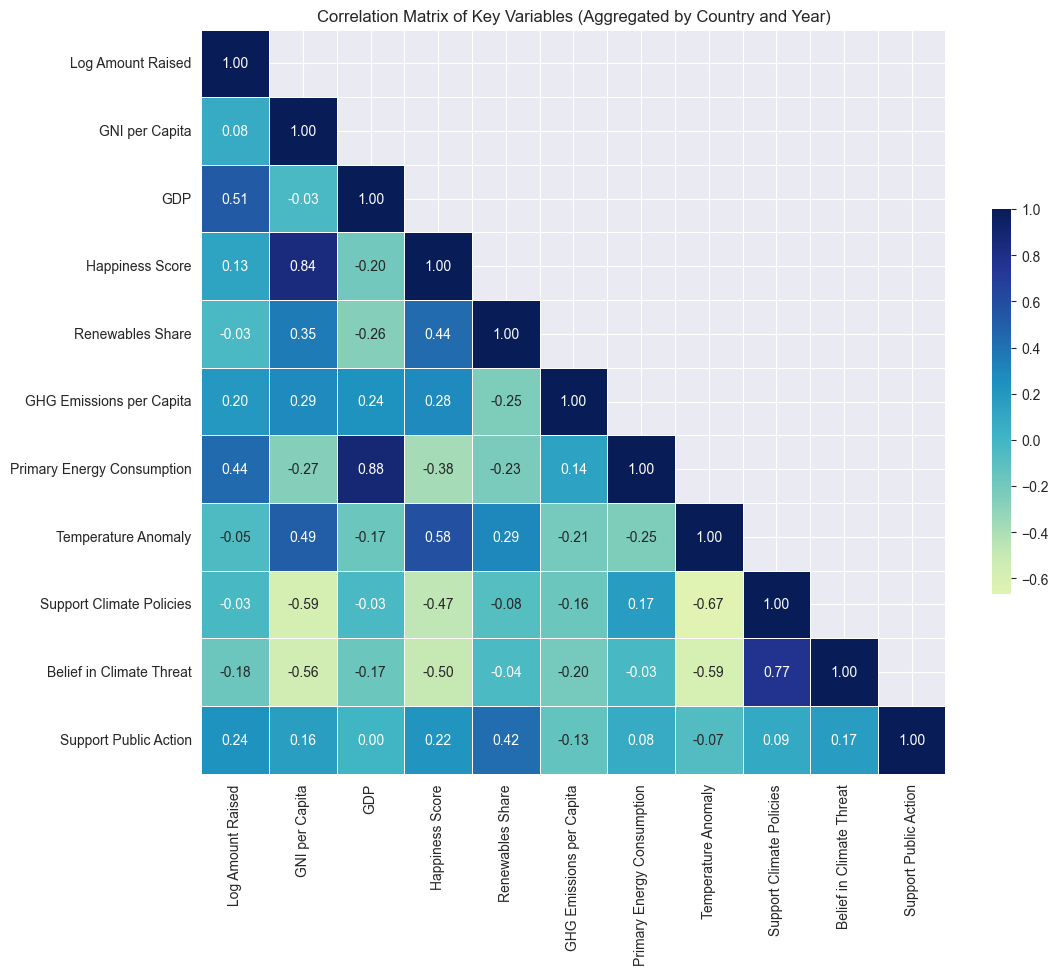

In [8]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure Kaleido is set up for Plotly, if you're also saving Plotly images
import plotly.io as pio
pio.kaleido.scope.default_format = "png"

# Your data aggregation code
fundraisers_agg = fundraisers_df.groupby(['country', 'year']).agg({
    'Amount Raised': 'sum',
    'GNI per Capita': 'mean',
    'GDP': 'mean',
    'Happiness Score': 'mean',
    'Renewables Share': 'mean',
    'GHG Emissions per Capita': 'mean',
    'Primary Energy Consumption': 'mean',
    'Temperature Anomaly': 'mean',
    'Support Climate Policies': 'mean',
    'Belief in Climate Threat': 'mean',
    'Support Public Action': 'mean'
}).reset_index()

# Apply log transformation to 'Amount Raised' to reduce skewness
fundraisers_agg['Log Amount Raised'] = np.log1p(fundraisers_agg['Amount Raised'])

# Select the columns for the correlation
corr_columns = ['Log Amount Raised', 'GNI per Capita', 'GDP', 'Happiness Score', 'Renewables Share',
                'GHG Emissions per Capita', 'Primary Energy Consumption', 'Temperature Anomaly',
                'Support Climate Policies', 'Belief in Climate Threat', 'Support Public Action']

# Drop rows with missing values in these columns
corr_df = fundraisers_agg[corr_columns].dropna()

# Compute the correlation matrix
corr_matrix = corr_df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# Set up a dedicated figure and axes for the heatmap
fig, ax = plt.subplots(figsize=(12, 10))

# Generate a custom colormap (you can choose any other suitable colormap)
cmap = sns.color_palette("YlGnBu", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, annot=True, fmt='.2f', cbar_kws={"shrink": .5}, ax=ax)

# Set the title
ax.set_title('Correlation Matrix of Key Variables (Aggregated by Country and Year)')

# Save the figure after ensuring it's rendered
fig_filename = os.path.join(visualizations_dir, 'correlation_matrix.png')
plt.savefig(fig_filename, dpi=600, bbox_inches='tight')
print(f"Figure saved to {fig_filename}")

# Show the plot if needed, after saving
plt.show()

- **Geographical Visualization** - World Map

Using [Admin 0 – Countries shapefile dataset](https://www.naturalearthdata.com/downloads/110m-cultural-vectors/) (this is the world map)

Figure saved to visualizations\2024-11-14_07-52-09\geog_dist_fundraisers_clean_tech_sector.png


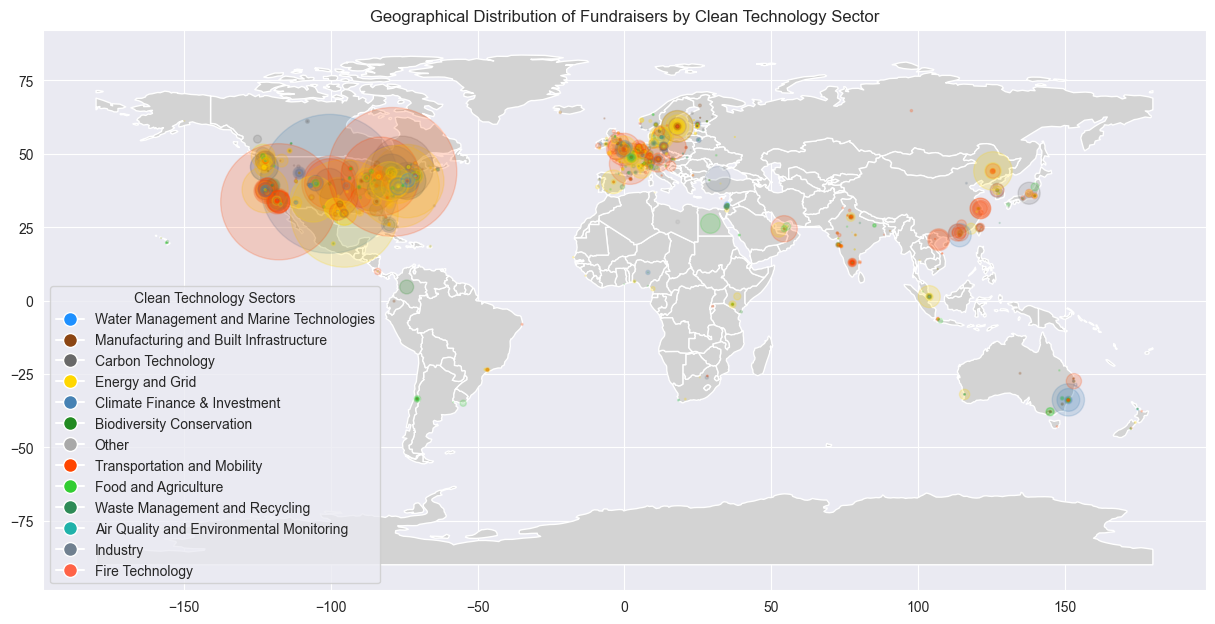

In [9]:
# Create a GeoDataFrame with points for each fundraiser based on latitude and longitude
fundraisers_with_geo_df = fundraisers_df[~fundraisers_df.latitude.isna() & ~fundraisers_df.longitude.isna()].reset_index(drop=True)
geometry = [Point(xy) for xy in zip(fundraisers_with_geo_df['longitude'], fundraisers_with_geo_df['latitude'])]
geo_df = gpd.GeoDataFrame(fundraisers_with_geo_df, geometry=geometry)

# Load world map (update the file path to where you saved the shapefiles)
world = gpd.read_file("ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")

# Assign colors to each clean technology sector
sector_colors = {
    'Water Management and Marine Technologies': '#1E90FF',   # Deep Sky Blue (water theme)
    'Manufacturing and Built Infrastructure': '#8B4513',     # Saddle Brown (industrial, construction theme)
    'Carbon Technology': '#696969',                          # Dim Gray (carbon, neutral color)
    'Energy and Grid': '#FFD700',                            # Gold (energy, grid, power)
    'Climate Finance & Investment': '#4682B4',               # Steel Blue (financial stability)
    'Biodiversity Conservation': '#228B22',                  # Forest Green (nature, conservation)
    'Other': '#A9A9A9',                                      # Dark Gray (neutral, unspecified)
    'Transportation and Mobility': '#FF4500',                # Orange Red (mobility, transportation)
    'Food and Agriculture': '#32CD32',                       # Lime Green (agriculture, plant life)
    'Waste Management and Recycling': '#2E8B57',             # Sea Green (recycling, sustainability)
    'Air Quality and Environmental Monitoring': '#20B2AA',   # Light Sea Green (air, environment)
    'Industry': '#708090',                                   # Slate Gray (industrial, machinery)
    'Fire Technology': '#FF6347'                             # Tomato (fire, emergency)
}

# Map the sector to colors
geo_df['sector_color'] = geo_df['clean_technology_sector'].map(sector_colors)

# Plot the world map
fig, ax = plt.subplots(figsize=(15, 10))
world.plot(ax=ax, color='lightgrey')

# Plot fundraiser locations by sector with unique colors
geo_df.plot(
    ax=ax, 
    markersize=geo_df['Amount Raised'] / 10000000,  # Adjust this scale as needed
    alpha=0.2, 
    color=geo_df['sector_color'], 
    legend=True
)

# Create a custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) 
           for color in sector_colors.values()]
labels = sector_colors.keys()
plt.legend(handles, labels, title="Clean Technology Sectors", loc='lower left')

# Set the title
plt.title('Geographical Distribution of Fundraisers by Clean Technology Sector')

# Save the figure before displaying it
fig_filename = os.path.join(visualizations_dir, 'geog_dist_fundraisers_clean_tech_sector.png')
fig.savefig(fig_filename, dpi=600, bbox_inches='tight')
print(f"Figure saved to {fig_filename}")

# Display the plot (optional)
plt.show()

- **Geographical Visualization** - Map of the U.S.A.

Figure saved to visualizations\2024-11-14_07-52-09\geog_dist_fundraisers_clean_tech_sector_usa.png


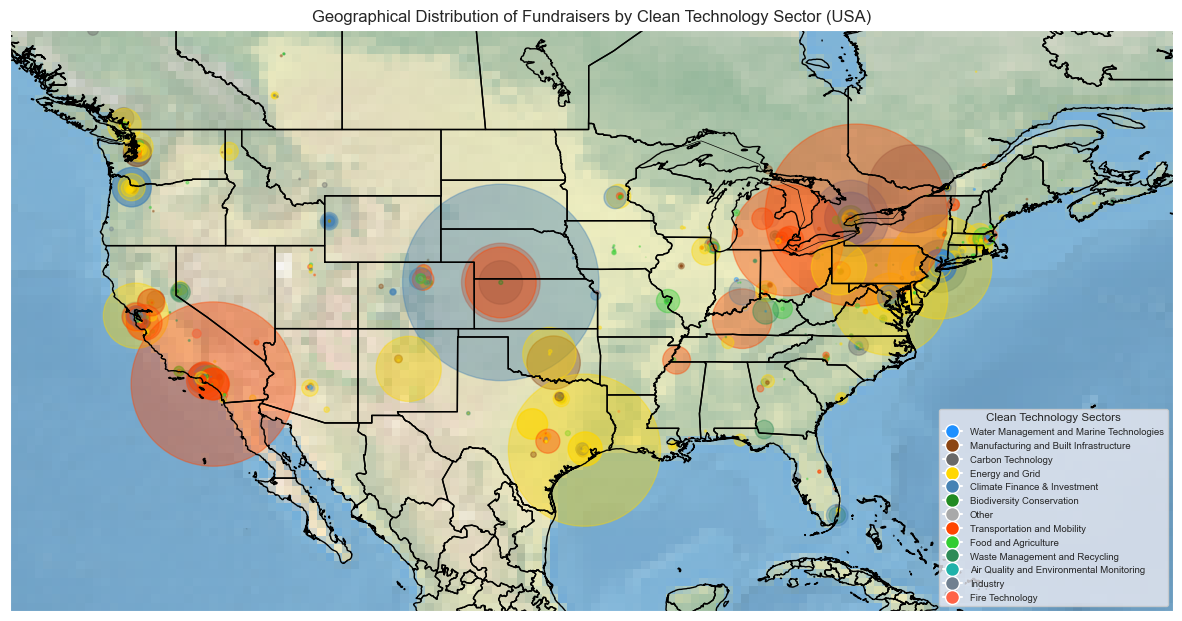

In [10]:
# Filter geo_df for North America region
geo_df_na = geo_df[
    (geo_df['longitude'] >= -170) & (geo_df['longitude'] <= -50) &  
    (geo_df['latitude'] >= 5) & (geo_df['latitude'] <= 85)
]

# Map the sector to colors
geo_df_na.loc[:, 'sector_color'] = geo_df_na['clean_technology_sector'].map(sector_colors)

# Set up Cartopy map with USA boundaries and state borders
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-130, -60, 20, 55], ccrs.PlateCarree())  # Focus on the USA

# Add a basic land and ocean background
ax.stock_img()

# Add state boundaries and coastlines
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.5)
ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='black')

# Plot the fundraisers
geo_df_na.plot(
    ax=ax,
    markersize=geo_df_na['Amount Raised'] / 5000000,
    alpha=0.4,
    color=geo_df_na['sector_color'],
    legend=True,
    transform=ccrs.PlateCarree()
)

# Create a custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) 
           for color in sector_colors.values()]
labels = sector_colors.keys()
plt.legend(handles, labels, title="Clean Technology Sectors", loc='lower right', 
           fontsize='x-small', title_fontsize='small')

# Add title
plt.title('Geographical Distribution of Fundraisers by Clean Technology Sector (USA)')

# Save the figure before displaying
fig_filename = os.path.join(visualizations_dir, 'geog_dist_fundraisers_clean_tech_sector_usa.png')
fig.savefig(fig_filename, dpi=600, bbox_inches='tight')
print(f"Figure saved to {fig_filename}")

# Display the plot
plt.show()

- **Bar Plot of Fundraisers by Continent**

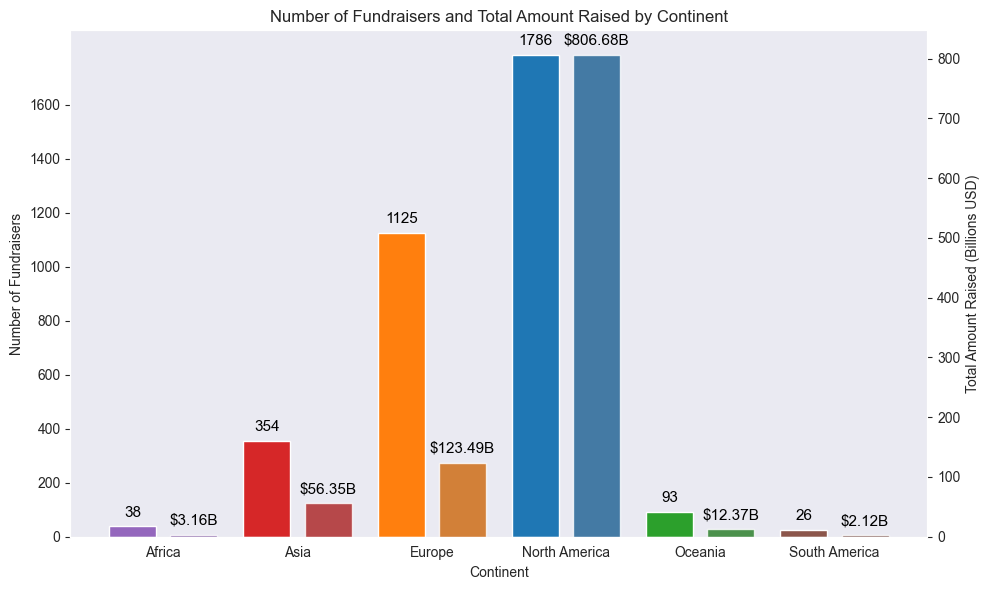

Figure saved to visualizations\2024-11-14_07-52-09\fundraisers_bar_plot.png


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define custom colors for each continent
continent_colors = {
    'North America': '#1f77b4',   # Blue
    'Europe': '#ff7f0e',          # Orange
    'Oceania': '#2ca02c',         # Green
    'Asia': '#d62728',            # Red
    'Africa': '#9467bd',          # Purple
    'South America': '#8c564b',   # Brown
}

# Darker colors for the total amount raised bars
darker_continent_colors = {
    'North America': '#1a5e91',   # Darker Blue
    'Europe': '#cc660a',          # Darker Orange
    'Oceania': '#237b22',         # Darker Green
    'Asia': '#aa2020',            # Darker Red
    'Africa': '#774e99',          # Darker Purple
    'South America': '#6f453a',   # Darker Brown
}

# Calculate the number of fundraisers and the total amount raised by continent
continent_stats = fundraisers_df.groupby('continent').agg({
    'fundraising_entity': 'count',  # Number of fundraisers
    'Amount Raised': 'sum'  # Total amount raised
}).reset_index().rename(columns={'fundraising_entity': 'Number of Fundraisers', 'Amount Raised': 'Total Amount Raised'})

# Convert 'Total Amount Raised' to billions
continent_stats['Total Amount Raised (Billions)'] = continent_stats['Total Amount Raised'] / 1e9

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Set the width for the bars
bar_width = 0.35

# Adjust the spacing between the two bars
bar_offset = bar_width * 1.3  # Increase offset to create space between bars

# Create the x values for the bars
x = np.arange(len(continent_stats['continent']))

# Plot the number of fundraisers as bars on ax1
ax1.bar(x - bar_offset/2, 
        continent_stats['Number of Fundraisers'], 
        width=bar_width, 
        color=[continent_colors[continent] for continent in continent_stats['continent']],
        label='Number of Fundraisers')

# Create a second y-axis (ax2) for the total amount raised
ax2 = ax1.twinx()

# Plot the total amount raised as bars on ax2 (slightly shifted further right)
ax2.bar(x + bar_offset/2, 
        continent_stats['Total Amount Raised (Billions)'], 
        width=bar_width, 
        color=[darker_continent_colors[continent] for continent in continent_stats['continent']],
        alpha=0.8, 
        label='Total Amount Raised (Billions)')

# Annotate the number of fundraisers on top of the bars in ax1
for i, v in enumerate(continent_stats['Number of Fundraisers']):
    ax1.annotate(f'{int(v)}', 
                 (x[i] - bar_offset/2, v), 
                 ha='center', va='bottom', fontsize=11, color='black', xytext=(0, 5), textcoords='offset points')

# Annotate the total amount raised in billions (rounded to 2 decimal places) on top of the bars in ax2
for i, v in enumerate(continent_stats['Total Amount Raised (Billions)']):
    ax2.annotate(f'${v:.2f}B', 
                 (x[i] + bar_offset/2, v), 
                 ha='center', va='bottom', fontsize=11, color='black', xytext=(0, 5), textcoords='offset points')

# Add titles and labels
ax1.set_title('Number of Fundraisers and Total Amount Raised by Continent')
ax1.set_xlabel('Continent')
ax1.set_ylabel('Number of Fundraisers')
ax2.set_ylabel('Total Amount Raised (Billions USD)')

# Set the x-axis tick labels
ax1.set_xticks(x)
ax1.set_xticklabels(continent_stats['continent'])

# Remove the legends since we annotate the bars directly
ax1.legend().remove()
ax2.legend().remove()

# Set the y-axis limits and ticks for ax1 and ax2 to align them
max_fundraisers = continent_stats['Number of Fundraisers'].max()
max_amount_raised = continent_stats['Total Amount Raised (Billions)'].max()

# Define custom tick intervals for each axis
num_fundraisers_ticks = np.arange(0, max_fundraisers + 3, 200)  # Interval of 300 for Number of Fundraisers

# Apply these ticks to each axis
ax1.set_yticks(num_fundraisers_ticks)

# Disable grid lines for both axes
ax1.grid(False)
ax2.grid(False)

# Set ticks to only show on the left and bottom for ax1, and on the right for ax2
ax1.tick_params(axis='y', which='both', left=True, right=False)
ax2.tick_params(axis='y', which='both', left=False, right=True)

# Show the plot
plt.tight_layout()
plt.show()

# Save the figure
fig_filename = os.path.join(visualizations_dir, 'fundraisers_bar_plot.png')
fig.savefig(fig_filename, dpi=300, bbox_inches='tight')
print(f"Figure saved to {fig_filename}")

- **Amount Raised over Time**

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

# Ensure 'date_of_funding_reported' is in datetime format
fundraisers_df['date_of_funding_reported'] = pd.to_datetime(fundraisers_df['date_of_funding_reported'])

# Remove the 'Climate Finance & Investment' sector
fundraisers_df = fundraisers_df[fundraisers_df.clean_technology_sector != 'Climate Finance & Investment']

# Aggregate data monthly
fundraisers_df['year_month'] = fundraisers_df['date_of_funding_reported'].dt.to_period('M')
sector_monthly = fundraisers_df.groupby(['clean_technology_sector', 'year_month'])['Amount Raised'].sum().reset_index()

# Pivot to have sectors as columns
sector_pivot = sector_monthly.pivot(index='year_month', columns='clean_technology_sector', values='Amount Raised').fillna(0)

# Log transform to handle wide-ranging values
sector_pivot_log = np.log1p(sector_pivot)

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Define forecast horizon (e.g., months until end of 2025)
forecast_periods = (2025 - sector_pivot_log.index.max().year) * 12 + (12 - sector_pivot_log.index.max().month)

# Container for forecasts
sector_forecasts = {}

for sector in sector_pivot_log.columns:
    ts = sector_pivot_log[sector]
    ts.index = ts.index.to_timestamp()  # Convert PeriodIndex to Timestamp

    # Check for stationarity (optional)
    adf_test = adfuller(ts)
    p_value = adf_test[1]

    # Differencing if not stationary
    d = 1 if p_value > 0.05 else 0

    # Fit SARIMA model (you may need to iterate to find the best parameters)
    model = SARIMAX(ts, order=(1,d,1), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)

    # Forecast
    pred_uc = results.get_forecast(steps=forecast_periods)
    pred_ci = pred_uc.conf_int()

    # Inverse log transform
    forecast_values = np.expm1(pred_uc.predicted_mean)
    lower_ci = np.expm1(pred_ci.iloc[:, 0])
    upper_ci = np.expm1(pred_ci.iloc[:, 1])

    # Store results
    sector_forecasts[sector] = {
        'historical': np.expm1(ts),
        'forecast': forecast_values,
        'lower_ci': lower_ci,
        'upper_ci': upper_ci,
        'model': results
    }

In [14]:
from prophet import Prophet

# Prepare data for Prophet
sector_forecasts = {}

for sector in sector_pivot.columns:
    df = sector_pivot[sector].reset_index()
    df.rename(columns={'year_month': 'ds', sector: 'y'}, inplace=True)
    df['ds'] = df['ds'].dt.to_timestamp()
    df['y'] = np.log1p(df['y'])  # Log-transform

    # Check for sufficient data points
    if df['y'].count() < 24:
        continue

    # Fit Prophet model
    model = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
    model.fit(df)

    # Create future dataframe
    future = model.make_future_dataframe(periods=forecast_periods, freq='MS')
    forecast = model.predict(future)

    # Inverse transform predictions
    forecast['yhat'] = np.expm1(forecast['yhat'])
    forecast['yhat_lower'] = np.expm1(forecast['yhat_lower'])
    forecast['yhat_upper'] = np.expm1(forecast['yhat_upper'])

    # Store results
    sector_forecasts[sector] = {
        'historical': np.expm1(df.set_index('ds')['y']),
        'forecast': forecast.set_index('ds'),
        'model': model
    }

07:52:21 - cmdstanpy - INFO - Chain [1] start processing
07:52:22 - cmdstanpy - INFO - Chain [1] done processing
07:52:22 - cmdstanpy - INFO - Chain [1] start processing
07:52:22 - cmdstanpy - INFO - Chain [1] done processing
07:52:22 - cmdstanpy - INFO - Chain [1] start processing
07:52:22 - cmdstanpy - INFO - Chain [1] done processing
07:52:22 - cmdstanpy - INFO - Chain [1] start processing
07:52:22 - cmdstanpy - INFO - Chain [1] done processing
07:52:23 - cmdstanpy - INFO - Chain [1] start processing
07:52:23 - cmdstanpy - INFO - Chain [1] done processing
07:52:23 - cmdstanpy - INFO - Chain [1] start processing
07:52:23 - cmdstanpy - INFO - Chain [1] done processing
07:52:23 - cmdstanpy - INFO - Chain [1] start processing
07:52:23 - cmdstanpy - INFO - Chain [1] done processing
07:52:23 - cmdstanpy - INFO - Chain [1] start processing
07:52:23 - cmdstanpy - INFO - Chain [1] done processing
07:52:23 - cmdstanpy - INFO - Chain [1] start processing
07:52:24 - cmdstanpy - INFO - Chain [1]

In [15]:
import plotly.graph_objects as go

# Define a color palette for plotting charts
climate_tech_sector_colors = {
    'Air Quality and Environmental Monitoring': '#66bb6a',
    'Biodiversity Conservation': '#ffa726',
    'Carbon Technology': '#78909c',
    'Climate Finance & Investment': '#ffca28',
    'Energy and Grid': '#ec407a',
    'Fire Technology': '#ef5350',
    'Food and Agriculture': '#9ccc65',
    'Industry': '#ab47bc',
    'Manufacturing and Built Infrastructure': '#5c6bc0',
    'Transportation and Mobility': '#26a69a',
    'Waste Management and Recycling': '#ff7043',
    'Water Management and Marine Technologies': '#26c6da'
}

climate_tech_sector_snake_case = {
    'Air Quality and Environmental Monitoring': 'air_quality_and_environmental_monitoring',
    'Biodiversity Conservation': 'biodiversity_conservation',
    'Carbon Technology': 'carbon_technology',
    'Climate Finance & Investment': 'climate_finance_and_investment',
    'Energy and Grid': 'energy_and_grid',
    'Fire Technology': 'fire_technology',
    'Food and Agriculture': 'food_and_agriculture',
    'Industry': 'industry',
    'Manufacturing and Built Infrastructure': 'manufacturing_and_built_infrastructure',
    'Transportation and Mobility': 'transportation_and_mobility',
    'Waste Management and Recycling': 'waste_management_and_recycling',
    'Water Management and Marine Technologies': 'water_management_and_marine_technologies',
    'Other': 'other'
}

for sector, data in sector_forecasts.items():
    historical = data['historical']
    forecast = data['forecast']

    # Get the color for the current sector
    sector_color = climate_tech_sector_colors.get(sector, 'blue')

    fig = go.Figure()

    # Historical data as scatter plot (no connecting lines)
    fig.add_trace(go.Scatter(
        x=historical.index,
        y=historical.values,
        mode='markers',  # Just plot points, no line
        name='Historical Data',
        marker=dict(color=sector_color, size=8, symbol='circle')
    ))

    # Forecasted data as line plot
    fig.add_trace(go.Scatter(
        x=forecast.index,
        y=forecast['yhat'],
        mode='lines',
        name='Forecast',
        line=dict(color=sector_color, dash='dash')
    ))

    # Confidence intervals (shaded area between upper and lower bounds)
    fig.add_trace(go.Scatter(
        x=forecast.index,
        y=forecast['yhat_upper'],
        mode='lines',
        name='Upper Confidence Interval',
        line=dict(color='lightgrey'),
        showlegend=False
    ))

    fig.add_trace(go.Scatter(
        x=forecast.index,
        y=forecast['yhat_lower'],
        mode='lines',
        name='Lower Confidence Interval',
        fill='tonexty',
        fillcolor='rgba(255, 165, 0, 0.2)',
        line=dict(color='lightgrey'),
        showlegend=False
    ))

    # Update layout for the log scale, with custom ticks starting from 1
    fig.update_layout(
        title=f'Forecast of Funds Raised for {sector}',
        xaxis_title='Date',
        yaxis_title='Amount Raised (USD)',
        yaxis=dict(
            type='log',
            tickvals=[1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10, 1e11, 1e12],
            ticktext=['1K', '10K', '100K', '1M', '10M', '100M', '1B', '10B', '100B', '1T'],
            range=[3, 12]  # Logarithmic range corresponding to 1K (10^3) to 1T (10^12)
        )
    )

    fig.show()
    
    fig_filename = os.path.join(visualizations_dir, f'{climate_tech_sector_snake_case[sector]}_timeseries.png')
        
    import plotly.io as pio
    pio.kaleido.scope.default_format = "png"
        
    try:
        fig.write_image(fig_filename, format="png", scale=2)
        print(f"Figure saved to {fig_filename}")
    except Exception as e:
        print(f"Failed to save figure for sector '{sector}': {e}")

Figure saved to visualizations\2024-11-14_07-52-09\air_quality_and_environmental_monitoring_timeseries.png


Figure saved to visualizations\2024-11-14_07-52-09\biodiversity_conservation_timeseries.png


Figure saved to visualizations\2024-11-14_07-52-09\carbon_technology_timeseries.png


Figure saved to visualizations\2024-11-14_07-52-09\energy_and_grid_timeseries.png


Figure saved to visualizations\2024-11-14_07-52-09\fire_technology_timeseries.png


Figure saved to visualizations\2024-11-14_07-52-09\food_and_agriculture_timeseries.png


Figure saved to visualizations\2024-11-14_07-52-09\industry_timeseries.png


Figure saved to visualizations\2024-11-14_07-52-09\manufacturing_and_built_infrastructure_timeseries.png


Figure saved to visualizations\2024-11-14_07-52-09\other_timeseries.png


Figure saved to visualizations\2024-11-14_07-52-09\transportation_and_mobility_timeseries.png


Figure saved to visualizations\2024-11-14_07-52-09\waste_management_and_recycling_timeseries.png


Figure saved to visualizations\2024-11-14_07-52-09\water_management_and_marine_technologies_timeseries.png


- **Amount Raised by Clean Tech Sector**

In [16]:
# Function to plot a bar graph of total funds raised by each sector
def plot_fundraisers_bar_chart(fundraisers_df):
    # Grouping data by sector and summing up the amounts raised
    sector_funds = fundraisers_df.groupby('clean_technology_sector')['Amount Raised'].sum().reset_index()
    sector_funds['is_other'] = sector_funds['clean_technology_sector'] == 'Other'
    sector_funds = sector_funds.sort_values(by='is_other', ascending=True).drop('is_other', axis=1)

    # Map sector names to their corresponding colors
    sector_funds['color'] = sector_funds['clean_technology_sector'].map(climate_tech_sector_colors)
    sector_funds['formatted_amount_raised'] = sector_funds['Amount Raised'].apply(lambda x: '$ ' + humanize.intword(x))

    # Convert 'Amount Raised' to log scale for better visualization of disparate amounts
    sector_funds['log_normalized_amount_raised'] = np.log(sector_funds['Amount Raised']) ** 5

    # Plotting the bar chart using Plotly Express
    fig = px.bar(sector_funds,
                 x='clean_technology_sector',
                 y='log_normalized_amount_raised',
                 text='formatted_amount_raised',
                 color='clean_technology_sector',
                 color_discrete_map=climate_tech_sector_colors)

    # Customizations for the plot
    fig.update_traces(texttemplate='%{text}', textposition='outside')
    fig.update_layout(
        xaxis_title='Clean Tech Sector',
        yaxis_title='Log of Amount Raised (USD)',
        yaxis=dict(
            tickvals=[np.log(x) ** 5 for x in [1e7, 1e8, 1e9, 1e10, 1e11, 1e12]],
            ticktext=['10M', '100M', '1B', '10B', '100B', '1T'],
            range=[np.log(1e7) ** 5, np.log(1e12) ** 5]
        ),
        legend_title='\t\t\tClimate Tech Sector',
        height=600,
        width=1240,
        legend=dict(
            x=0.75,  # Move legend to the right (closer to the plot)
            y=1.1,  # Place the legend at the top of the plot
            traceorder="normal",
            bgcolor='rgba(255, 255, 255, 0.2)',  # Semi-transparent background for the legend
            bordercolor='Black',
            borderwidth=1
        ),
        margin=dict(r=40)  # Reduce right margin
    )
    fig.update_xaxes(categoryorder='total descending')
    return fig

fig = plot_fundraisers_bar_chart(fundraisers_df)

fig_filename = os.path.join(visualizations_dir, 'clean_tech_sector_funds_raised_bar_plot.png')
fig.write_image(fig_filename, scale=2)
print(f"Figure saved to {fig_filename}")

fig.show()

Figure saved to visualizations\2024-11-14_07-52-09\clean_tech_sector_funds_raised_bar_plot.png


### **1.6 Analysis of Temperature Anomalies and Clean Tech Investment**

**Objective:** Investigate whether countries experiencing higher temperature anomalies are receiving more investment in clean technology sectors.

#### **1.6.1 Exploratory Data Analysis**

We will explore the relationship between temperature anomalies and the amount raised in clean tech fundraisers.

**Distribution of Temperature Anomalies**


Figure saved to visualizations\2024-11-14_07-52-09\dist_temp_anomalies.png


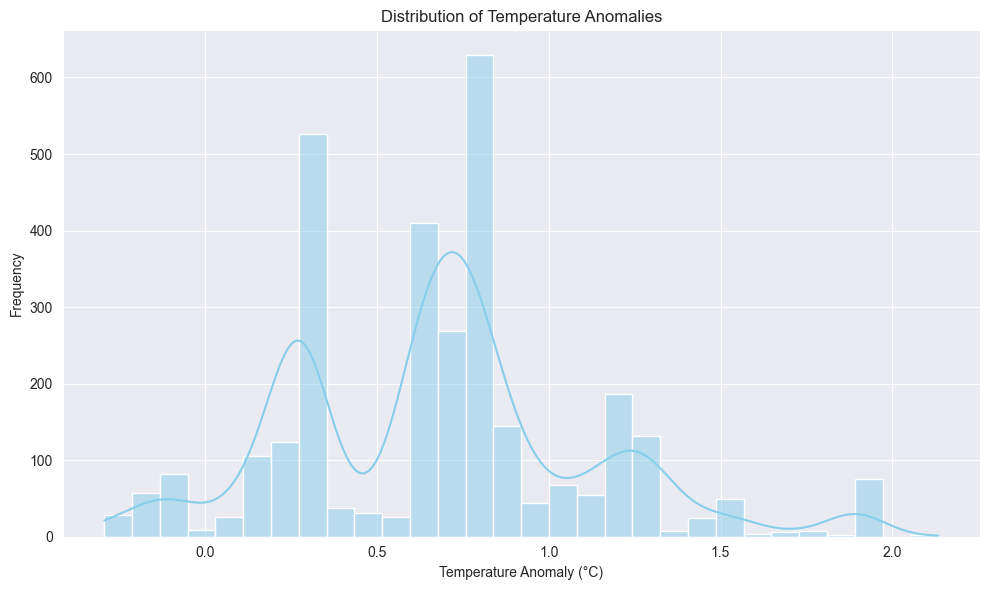

In [17]:
# Distribution of Temperature Anomalies
plt.figure(figsize=(10,6))
sns.histplot(fundraisers_df['Temperature Anomaly'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Temperature Anomalies')
plt.xlabel('Temperature Anomaly (°C)')
plt.ylabel('Frequency')
plt.tight_layout()

# Save the figure
fig_filename = os.path.join(visualizations_dir, 'dist_temp_anomalies.png')
plt.savefig(fig_filename, dpi=300, bbox_inches='tight')
print(f"Figure saved to {fig_filename}")

plt.show()

**Scatter Plot of Amount Raised vs. Temperature Anomaly**

In [18]:
climate_tech_sector_colors['Other'] = '#000000'

Figure saved to visualizations\2024-11-14_07-52-09\amount_raised_vs_temperature_anomaly.png


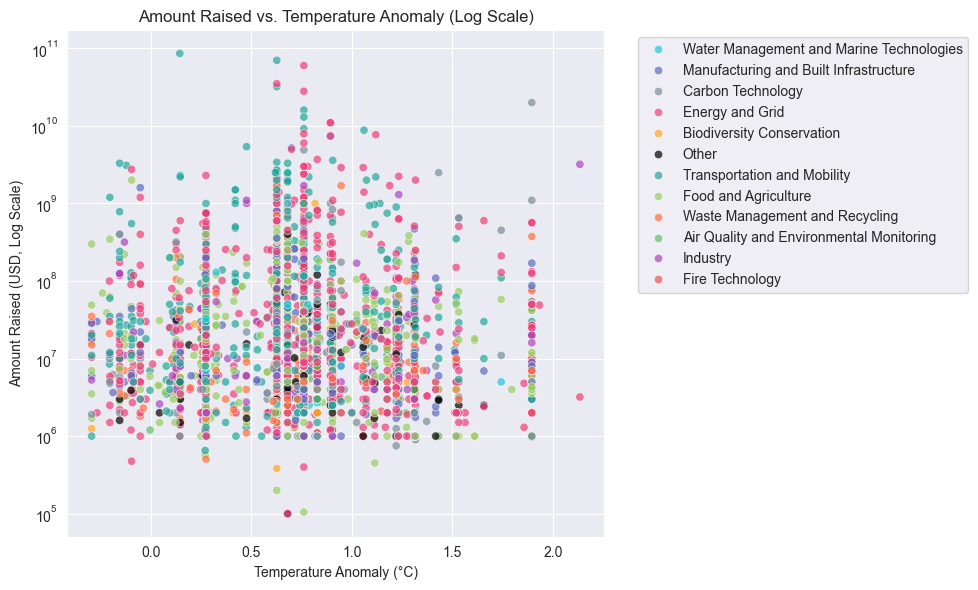

In [19]:
# Scatter plot with log scale
plt.figure(figsize=(10,6))
sns.scatterplot(data=fundraisers_df, x='Temperature Anomaly', y='Amount Raised', hue='clean_technology_sector', alpha=0.7, palette=climate_tech_sector_colors)
plt.yscale('log')
plt.title('Amount Raised vs. Temperature Anomaly (Log Scale)')
plt.xlabel('Temperature Anomaly (°C)')
plt.ylabel('Amount Raised (USD, Log Scale)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the figure
fig_filename = os.path.join(visualizations_dir, 'amount_raised_vs_temperature_anomaly.png')
plt.savefig(fig_filename, dpi=300, bbox_inches='tight')
print(f"Figure saved to {fig_filename}")

plt.show()

### **1.7 Relationship between CO Emissions per Capita and Clean Tech Investment**

**Objective:** Investigate whether countries with higher CO emissions per capita are receiving more investment in clean technology sectors.

#### **1.7.1 Load and Prepare CO Emissions Data**

**Load CO Emissions per Capita Data**

In [20]:
# Load CO Emissions per Capita data
co2_emissions_df = pd.read_csv('data/co-emissions-per-capita.csv')

# Prepare the data
co2_emissions_df = co2_emissions_df[['Entity', 'Year', 'Annual CO₂ emissions (per capita)']].dropna()
co2_emissions_df.rename(columns={'Entity': 'country', 'Year': 'year', 'Annual CO emissions (per capita)': 'co2_per_capita'}, inplace=True)

# Standardize country names
co2_emissions_df['country'] = co2_emissions_df['country'].replace(country_name_mapping)


**Merge with Main Dataset**


In [21]:
# Merge with fundraisers_df
fundraisers_df = fundraisers_df.merge(co2_emissions_df, on=['country', 'year'], how='left')

# Handle missing values
fundraisers_df['co2_per_capita'] = fundraisers_df.groupby('country')['Annual CO₂ emissions (per capita)'].transform(lambda x: x.fillna(x.median()))
fundraisers_df['co2_per_capita'].fillna(fundraisers_df['co2_per_capita'].median(), inplace=True)


#### **1.7.2 Exploratory Data Analysis**

**Scatter Plot of Amount Raised vs. CO$_2$ Emissions per Capita**


Figure saved to visualizations\2024-11-14_07-52-09\amount_raised_vs_co2_emissions_per_capita.png


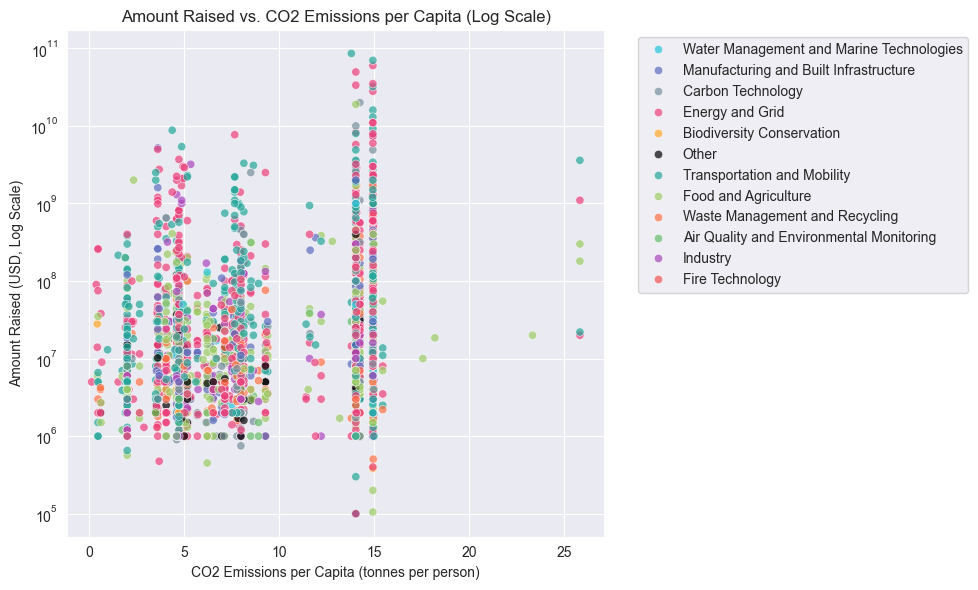

In [22]:
# Scatter plot with log scale
plt.figure(figsize=(10,6))
sns.scatterplot(data=fundraisers_df, x='co2_per_capita', y='Amount Raised', hue='clean_technology_sector', alpha=0.7, palette=climate_tech_sector_colors)
plt.yscale('log')
plt.title('Amount Raised vs. CO2 Emissions per Capita (Log Scale)')
plt.xlabel('CO2 Emissions per Capita (tonnes per person)')
plt.ylabel('Amount Raised (USD, Log Scale)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the figure
fig_filename = os.path.join(visualizations_dir, 'amount_raised_vs_co2_emissions_per_capita.png')
plt.savefig(fig_filename, dpi=300, bbox_inches='tight')
print(f"Figure saved to {fig_filename}")

plt.show()

### **Step 2: Feature Engineering**

**Objective:** Enhance the dataset by creating new features and preparing it for modeling.

### **2.1 Handle Categorical Variables:**

- **One-Hot Encoding for Sector** - We will perform one-hot encoding on the clean_technology_sector column to convert it into numerical features suitable for modeling.

In [23]:
# One-Hot Encoding for 'clean_technology_sector' without dropping the original column
sector_dummies = pd.get_dummies(fundraisers_df['clean_technology_sector'], prefix='sector')

# Concatenate the new one-hot encoded columns back to the original dataframe
fundraisers_df = pd.concat([fundraisers_df, sector_dummies], axis=1)

- **Label Encoding for Country and Continent**

In [24]:
from sklearn.preprocessing import LabelEncoder

le_country = LabelEncoder()
fundraisers_df['country_encoded'] = le_country.fit_transform(fundraisers_df['country'].astype(str))

le_continent = LabelEncoder()
fundraisers_df['continent_encoded'] = le_continent.fit_transform(fundraisers_df['continent'].astype(str))

### **2.2 Impute Missing Values:**

- **Impute Missing Macroeconomic Indicators** - We will impute missing values using a hierarchical approach:
    - Country-level Median: Fill missing values using the median value for the same country.
    - Overall Median: If still missing, fill with the overall median.

In [25]:
# List of features to impute
impute_features = [
    'GNI per Capita',
    'Happiness Score',
    'Renewables Share',
    'GHG Emissions per Capita',
    'Primary Energy Consumption',
    'Temperature Anomaly',
    'Support Climate Policies',
    'Belief in Climate Threat',
    'Support Public Action',
    'GDP',
    'latitude',
    'longitude'
]

# Perform hierarchical imputation
for feature in impute_features:
    # Fill missing values using median for the same country
    fundraisers_df[feature] = fundraisers_df.groupby('country')[feature].transform(lambda x: x.fillna(x.median()))
    # Fill remaining missing values with overall median
    fundraisers_df[feature].fillna(fundraisers_df[feature].median(), inplace=True)

### **2.3 Normalize Numerical Features:**

- **Standard Scaling** - We will standardize numerical features to have a mean of 0 and a standard deviation of 1, which is essential for models that are sensitive to the scale of data.

In [26]:
from sklearn.preprocessing import StandardScaler

# Create a copy of the original 'Amount Raised' before scaling
fundraisers_df['Amount Raised Original'] = fundraisers_df['Amount Raised']

# List of numerical features
numerical_features = [
    'Amount Raised',
    'GNI per Capita',
    'Happiness Score',
    'Renewables Share',
    'GHG Emissions per Capita',
    'Primary Energy Consumption',
    'Temperature Anomaly',
    'Support Climate Policies',
    'Belief in Climate Threat',
    'Support Public Action',
    'GDP',
    'latitude',
    'longitude'
]

# Standard Scaling
scaler = StandardScaler()
fundraisers_df[numerical_features] = scaler.fit_transform(fundraisers_df[numerical_features])

### **2.4 Create Interaction Terms:**

- **Interaction between Economic and Environmental Indicators**

In [27]:
# Interaction between GNI per Capita and Renewables Share
fundraisers_df['gni_renewables_interaction'] = fundraisers_df['GNI per Capita'] * fundraisers_df['Renewables Share']

# Interaction between GNI per Capita and GHG Emissions per Capita
fundraisers_df['gni_ghg_interaction'] = fundraisers_df['GNI per Capita'] * fundraisers_df['GHG Emissions per Capita']

# Interaction between GNI per Capita and Temperature Anomaly
fundraisers_df['gni_temperature_anomaly_interaction'] = fundraisers_df['GNI per Capita'] * fundraisers_df['Temperature Anomaly']

# Interaction between GNI per Capita and Support Climate Policies
fundraisers_df['gni_climate_policy_interaction'] = fundraisers_df['GNI per Capita'] * fundraisers_df['Support Climate Policies']

### **2.5 Temporal Features:**

- **Extract Month and Quarter**

In [28]:
# Ensure 'date_of_funding_reported' is datetime
fundraisers_df['date_of_funding_reported'] = pd.to_datetime(fundraisers_df['date_of_funding_reported'])

# Extract 'month' and 'quarter'
fundraisers_df['month'] = fundraisers_df['date_of_funding_reported'].dt.month
fundraisers_df['quarter'] = fundraisers_df['date_of_funding_reported'].dt.quarter

### **2.6 Prepare Feature Matrix for Modeling:**

- Prepare the feature matrix `X` and target variables `y_reg` and `y_cls` for regression and classification.

In [29]:
# Define features for modeling
model_features = numerical_features + [
    'gni_renewables_interaction',
    'gni_ghg_interaction',
    'gni_temperature_anomaly_interaction',
    'gni_climate_policy_interaction',
    'country_encoded',
    'continent_encoded'
] + [col for col in fundraisers_df.columns if col.startswith('sector_')]

# Ensure there are no missing values in the features
assert fundraisers_df[model_features].isnull().sum().sum() == 0, "There are still missing values in the features."

# Target variable for regression
y_reg = fundraisers_df['Amount Raised']

# Target variable for classification
# Define high impact threshold (e.g., top 25% of Amount Raised)
high_impact_threshold = fundraisers_df['Amount Raised'].quantile(0.75)
# Label the data
fundraisers_df['high_impact'] = (fundraisers_df['Amount Raised'] >= high_impact_threshold).astype(int)
y_cls = fundraisers_df['high_impact']

### **Step 3: Building the Recommender System**

**Objective:** Develop a comprehensive recommendation system that advises investors on which clean technology sectors to invest in, where, how much, and when, to maximize impact and value in solving climate change and improving societal well-being.

### 3.1 Implement Task 1: Similar Fundraiser Recommendation

#### 3.1.1 Text Embedding of Fundraiser Descriptions

In [30]:
from sentence_transformers import SentenceTransformer
import torch

# Load the pre-trained model with CUDA if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

fundraisers_df = fundraisers_df.reset_index(drop=True)

# Compute embeddings for fundraiser descriptions with progress tracking
total_descriptions = len(fundraisers_df)
fundraisers_df['description_embedding'] = None  # Initialize an empty column

for idx, row in fundraisers_df.iterrows():
    description = row['fundraiser_description']
    # Encode with the model and add to the DataFrame
    fundraisers_df.at[idx, 'description_embedding'] = model.encode(str(description), device=device)
    
    # Calculate progress
    if idx % 300 == 0 or idx == len(fundraisers_df) - 1:
        completion_percentage = (idx + 1) / total_descriptions * 100
        
        # Print the progress
        print(f"Completed index {idx + 1}/{total_descriptions} - {completion_percentage:.2f}%")

Completed index 1/3348 - 0.03%
Completed index 301/3348 - 8.99%
Completed index 601/3348 - 17.95%
Completed index 901/3348 - 26.91%
Completed index 1201/3348 - 35.87%
Completed index 1501/3348 - 44.83%
Completed index 1801/3348 - 53.79%
Completed index 2101/3348 - 62.75%
Completed index 2401/3348 - 71.71%
Completed index 2701/3348 - 80.68%
Completed index 3001/3348 - 89.64%
Completed index 3301/3348 - 98.60%
Completed index 3348/3348 - 100.00%


#### 3.1.2 Incorporate additional features based on the correlation analysis

In [31]:
# Interaction Terms already exist
# Consider adding lag features or moving averages if applicable
# For example, previous month's Amount Raised
fundraisers_df = fundraisers_df.sort_values(['country', 'clean_technology_sector', 'date_of_funding_reported'])

# Create lag features
fundraisers_df['lag_1_amount'] = fundraisers_df.groupby(['country', 'clean_technology_sector'])['Amount Raised'].shift(1)
fundraisers_df['lag_3_amount'] = fundraisers_df.groupby(['country', 'clean_technology_sector'])['Amount Raised'].shift(3)

# Moving averages
fundraisers_df['ma_3_amount'] = fundraisers_df.groupby(['country', 'clean_technology_sector'])['Amount Raised'].transform(lambda x: x.rolling(window=3).mean())

# Fill NaN values resulting from lag features
fundraisers_df.fillna(method='bfill', inplace=True)

#### 3.1.3 Update Feature List for Modeling

In [32]:
# Update numerical features
numerical_features += [
    'lag_1_amount',
    'lag_3_amount',
    'ma_3_amount'
]

# Re-normalize after adding new features
fundraisers_df[numerical_features] = scaler.fit_transform(fundraisers_df[numerical_features])

# Update model features
model_features += [
    'lag_1_amount',
    'lag_3_amount',
    'ma_3_amount'
]

#### 3.1.4 Regression Model for Investment Amount Prediction

In [33]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def predict_investment_amount(df, model=None, scaler=None):
    """
    Predict investment amount using LightGBM regression.

    Parameters:
    - df (DataFrame): Time series data with necessary features.
    - model (object): Pre-trained LightGBM model. If None, train a new model.
    - scaler (object): Scaler used for 'Amount Raised'. If provided, inverse transform predictions.

    Returns:
    - model (object): Trained LightGBM model.
    """
    # Define feature columns
    feature_cols = [
        'year', 'month', 'GNI per Capita', 'GDP', 'Happiness Score',
        'Renewables Share', 'GHG Emissions per Capita',
        'Primary Energy Consumption', 'Temperature Anomaly',
        'Support Climate Policies', 'Belief in Climate Threat',
        'Support Public Action', 'gni_renewables_interaction',
        'gni_ghg_interaction', 'gni_temperature_anomaly_interaction',
        'gni_climate_policy_interaction', 'lag_1_amount', 'lag_3_amount',
        'ma_3_amount'
    ]

    # Check if all feature columns are present
    missing_features = [col for col in feature_cols if col not in df.columns]
    if missing_features:
        raise ValueError(f"Missing features: {missing_features}")

    X = df[feature_cols]
    y = df['y']  # 'y' is the scaled and log-transformed 'Amount Raised'

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if model is None:
        # Initialize LightGBM regressor with enhanced parameters
        model = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            num_leaves=31,
            max_depth=-1,
            min_child_samples=20,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
        )

        # Fit the model
        model.fit(
            X_train, y_train,
            eval_set=[(X_test, y_test)],
            eval_metric='rmse',
            verbose=0
        )

    # After training your LightGBM model
    importance_df = pd.DataFrame({
        'feature': model.feature_name_,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=False)
    
    print("Feature Importances:")
    print(importance_df)

    # Predict and evaluate
    y_pred = model.predict(X_test, num_iteration=model.best_iteration_)

    # Inverse log transformation
    y_pred_exp = np.expm1(y_pred)
    y_test_exp = np.expm1(y_test)

    # Inverse scaling if scaler is provided
    if scaler:
        y_pred_inv = y_pred_exp  # Since we used original amounts for 'y', no scaling needed
        y_test_inv = y_test_exp
    else:
        y_pred_inv = y_pred_exp
        y_test_inv = y_test_exp

    mse = mean_squared_error(y_test_inv, y_pred_inv)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)
    print(f'MSE: {mse}, MAE: {mae}, R2: {r2}')

    return model

#### 3.1.5 Prepare Data for Time-Series Forecasting

In [34]:
def prepare_time_series_data(sector, country):
    """
    Prepare time series data with necessary features for a given sector and country.

    Parameters:
    - sector (str): The clean technology sector.
    - country (str): The country name.

    Returns:
    - DataFrame: Time series data with features.
    """
    # Filter data for the specified sector and country
    df = fundraisers_df[(fundraisers_df['clean_technology_sector'] == sector) &
                        (fundraisers_df['country'] == country)].copy()

    # Sort by date
    df = df.sort_values('date_of_funding_reported')

    # Aggregate Amount Raised by date
    df = df.groupby('date_of_funding_reported')['Amount Raised Original'].sum().reset_index()
    df.rename(columns={'date_of_funding_reported': 'ds', 'Amount Raised Original': 'y'}, inplace=True)

    # Log-transform 'y' to stabilize variance
    df['y'] = np.log1p(df['y'])

    # Add 'cap' and 'floor' for logistic growth
    df['cap'] = df['y'].max() * 1.5   # Adjust as needed
    df['floor'] = 0                   # Amount Raised cannot be negative

    # Add temporal features
    df['year'] = df['ds'].dt.year
    df['month'] = df['ds'].dt.month

    # Create lag features
    df['lag_1_amount'] = df['y'].shift(1)
    df['lag_3_amount'] = df['y'].shift(3)

    # Moving averages
    df['ma_3_amount'] = df['y'].rolling(window=3).mean()

    # Fill NaN values resulting from lag features
    df.fillna(method='bfill', inplace=True)

    # Merge with macroeconomic and climate indicators
    indicators = [
        'GNI per Capita',
        'GDP',
        'Happiness Score',
        'Renewables Share',
        'GHG Emissions per Capita',
        'Primary Energy Consumption',
        'Temperature Anomaly',
        'Support Climate Policies',
        'Belief in Climate Threat',
        'Support Public Action',
        'gni_renewables_interaction',
        'gni_ghg_interaction',
        'gni_temperature_anomaly_interaction',
        'gni_climate_policy_interaction'
    ]

    # Since indicators are constant over time in this context, take the median values
    indicator_df = fundraisers_df[(fundraisers_df['clean_technology_sector'] == sector) &
                                  (fundraisers_df['country'] == country)].copy()
    indicator_df['ds'] = indicator_df['date_of_funding_reported'].dt.to_period('M').dt.to_timestamp()
    indicator_agg = indicator_df.groupby('ds')[indicators].median().reset_index()

    # Merge with the main time series data
    df = pd.merge(df, indicator_agg, on='ds', how='left')

    # Fill any remaining NaN values
    df[indicators] = df[indicators].fillna(method='bfill').fillna(method='ffill')

    return df

#### 3.1.6 Content-Based Similarity Using Text Embeddings

In [35]:
# === Create the Country Similarity Matrix ===

# List of indicators to use for country similarity
country_indicators = [
    'GNI per Capita',
    'GDP',
    'Happiness Score',
    'Renewables Share',
    'GHG Emissions per Capita',
    'Primary Energy Consumption',
    'Temperature Anomaly',
    'Support Climate Policies',
    'Belief in Climate Threat',
    'Support Public Action',
]

# Create a DataFrame with country-level features
country_features_df = fundraisers_df.groupby('country')[country_indicators].mean().reset_index()

# Handle missing values if any
country_features_df[country_indicators] = country_features_df[country_indicators].fillna(country_features_df[country_indicators].mean())

# Normalize the features
scaler = MinMaxScaler()
country_features_df[country_indicators] = scaler.fit_transform(country_features_df[country_indicators])

# Add an 'Unknown' country with feature values set to zero
unknown_country = 'Unknown'
unknown_features = {feature: 0.0 for feature in country_indicators}
unknown_row = pd.DataFrame([{**{'country': unknown_country}, **unknown_features}])

# Append the 'Unknown' country to country_features_df
country_features_df = pd.concat([country_features_df, unknown_row], ignore_index=True)

# Create a mapping from country to index, including 'Unknown'
country_to_idx = {country: idx for idx, country in enumerate(country_features_df['country'])}

# Extract feature vectors
country_feature_vectors = country_features_df[country_indicators].values

# Compute the country similarity matrix
country_similarity_matrix = cosine_similarity(country_feature_vectors)

# Identify the index of the 'Unknown' country
unknown_idx = country_to_idx[unknown_country]

# Set similarity of 'Unknown' with all countries to zero
country_similarity_matrix[unknown_idx, :] = 0
country_similarity_matrix[:, unknown_idx] = 0

# Optionally, set similarity of 'Unknown' with itself to 1 (if desired)
country_similarity_matrix[unknown_idx, unknown_idx] = 1

# Map countries in fundraisers_df to indices in the country similarity matrix
# Assign 'Unknown' index to missing or None country values

# Define a condition for missing countries
missing_country_condition = fundraisers_df['country'].isna()

# Map existing countries to indices
fundraisers_df['country_idx'] = fundraisers_df['country'].map(country_to_idx)

# Assign 'Unknown' index to missing countries
fundraisers_df.loc[missing_country_condition, 'country_idx'] = country_to_idx[unknown_country]

# Ensure 'country_idx' is integer type
fundraisers_df['country_idx'] = fundraisers_df['country_idx'].astype(int)

# === Continue with Remaining Code ===

# Get the country indices for all fundraisers
fundraiser_country_indices = fundraisers_df['country_idx'].values

# Number of fundraisers
num_fundraisers = len(fundraisers_df)

# Create matrices of country indices for all pairs of fundraisers
country_idx_matrix_i = np.tile(fundraiser_country_indices, (num_fundraisers, 1))
country_idx_matrix_j = country_idx_matrix_i.T

# Compute country similarity matrix for fundraisers
country_similarity_fundraisers = country_similarity_matrix[country_idx_matrix_i, country_idx_matrix_j]

# === Load and Prepare GHG Emissions Data ===

# Load GHG Emissions by Sector data
ghg_emissions_sector_df = pd.read_csv('data/ghg-emissions-by-sector.csv')

# Select relevant columns
ghg_emissions_sector_df = ghg_emissions_sector_df[['Entity', 'Year',
    'Greenhouse gas emissions from agriculture',
    'Greenhouse gas emissions from land use change and forestry',
    'Greenhouse gas emissions from waste',
    'Greenhouse gas emissions from buildings',
    'Greenhouse gas emissions from industry',
    'Greenhouse gas emissions from manufacturing and construction',
    'Greenhouse gas emissions from transport',
    'Greenhouse gas emissions from electricity and heat',
    'Fugitive emissions of greenhouse gases from energy production',
    'Greenhouse gas emissions from other fuel combustion',
    'Greenhouse gas emissions from bunker fuels']]

# Handle missing values
ghg_emissions_sector_df.fillna(0, inplace=True)

# Sum emissions across all countries for the most recent year available
latest_year = ghg_emissions_sector_df['Year'].max()
ghg_emissions_latest = ghg_emissions_sector_df[ghg_emissions_sector_df['Year'] == latest_year]

# Sum emissions by sector globally
sector_emissions = ghg_emissions_latest.drop(columns=['Entity', 'Year']).sum().reset_index()
sector_emissions.columns = ['Sector', 'Emissions']
sector_emissions['Emissions'] = sector_emissions['Emissions'] / 1e6  # Convert to gigatonnes (Gt)

# Define mapping from GHG sectors to clean technology sectors
ghg_to_clean_tech_sector_map = {
    'Greenhouse gas emissions from agriculture': 'Food and Agriculture',
    'Greenhouse gas emissions from land use change and forestry': 'Biodiversity Conservation',
    'Greenhouse gas emissions from waste': 'Waste Management and Recycling',
    'Greenhouse gas emissions from buildings': 'Manufacturing and Built Infrastructure',
    'Greenhouse gas emissions from industry': 'Industry',
    'Greenhouse gas emissions from manufacturing and construction': 'Manufacturing and Built Infrastructure',
    'Greenhouse gas emissions from transport': 'Transportation and Mobility',
    'Greenhouse gas emissions from electricity and heat': 'Energy and Grid',
    'Fugitive emissions of greenhouse gases from energy production': 'Energy and Grid',
    'Greenhouse gas emissions from other fuel combustion': 'Energy and Grid',
    'Greenhouse gas emissions from bunker fuels': 'Transportation and Mobility'
}

# Apply the mapping to the emissions data
sector_emissions['clean_technology_sector'] = sector_emissions['Sector'].map(ghg_to_clean_tech_sector_map)

# Aggregate emissions by clean tech sector
sector_emissions_agg = sector_emissions.groupby('clean_technology_sector')['Emissions'].sum().reset_index()

# === Calculate Total Funding by Sector ===

# Group by clean technology sector and sum the amounts raised
sector_funding = fundraisers_df.groupby('clean_technology_sector')['Amount Raised Original'].sum().reset_index()
sector_funding.columns = ['clean_technology_sector', 'Total Funding']

# Merge the sector emissions and sector funding
emissions_funding_df = pd.merge(sector_emissions_agg, sector_funding, on='clean_technology_sector', how='outer')

# Handle missing values
emissions_funding_df['Emissions'] = emissions_funding_df['Emissions'].fillna(0)
emissions_funding_df['Total Funding'] = emissions_funding_df['Total Funding'].fillna(0)

# === Create the Sector Impact DataFrame ===

# List of unique clean technology sectors
sector_names = fundraisers_df['clean_technology_sector'].unique()

# Initialize the SentenceTransformer model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sector_embedding_model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

# Generate embeddings for sector names
sector_name_embeddings = sector_embedding_model.encode(sector_names, device=device)

# Create sector impact dataframe
sector_impact_df = emissions_funding_df[['clean_technology_sector', 'Emissions', 'Total Funding']]

# Add the sector name embeddings to the dataframe
sector_embeddings_df = pd.DataFrame(sector_name_embeddings, columns=[f'embedding_{i}' for i in range(sector_name_embeddings.shape[1])])
sector_embeddings_df['clean_technology_sector'] = sector_names

# Merge the embeddings with the sector impact dataframe
sector_impact_df = pd.merge(sector_impact_df, sector_embeddings_df, on='clean_technology_sector', how='left')

# === Normalize the Sector Features ===
sector_indicators = ['Emissions', 'Total Funding']

# Normalize the sector features
scaler = MinMaxScaler()
sector_impact_df[sector_indicators] = scaler.fit_transform(sector_impact_df[sector_indicators])

# === Create Sector Similarity Matrix ===

# Create a mapping from sector to index
sector_to_idx = {sector: idx for idx, sector in enumerate(sector_impact_df['clean_technology_sector'])}

# Map sectors in fundraisers_df to indices
fundraisers_df['sector_idx'] = fundraisers_df['clean_technology_sector'].map(sector_to_idx)

# Extract feature vectors
sector_feature_vectors = sector_impact_df[sector_indicators].values

# Compute the sector similarity matrix
sector_similarity_matrix = cosine_similarity(sector_feature_vectors)

# === Update the Fundraisers DataFrame ===

# Create a mapping from country to index (if not already done)
country_to_idx = {country: idx for idx, country in enumerate(country_features_df['country'])}
fundraisers_df['country_idx'] = fundraisers_df['country'].map(country_to_idx)

# Drop rows with missing 'country_idx' or 'sector_idx' and reset the index
fundraisers_df = fundraisers_df.dropna(subset=['country_idx', 'sector_idx']).reset_index(drop=True)

# Ensure 'country_idx' and 'sector_idx' are integers
fundraisers_df['country_idx'] = fundraisers_df['country_idx'].astype(int)
fundraisers_df['sector_idx'] = fundraisers_df['sector_idx'].astype(int)

# === Compute Description Similarity Matrix ===

# Create a matrix of description embeddings
description_embeddings = np.vstack(fundraisers_df['description_embedding'].values)

# Compute the description similarity matrix
description_similarity_matrix = cosine_similarity(description_embeddings)

# === Compute Fundraiser-Level Country and Sector Similarity Matrices ===

# Get the indices for the fundraisers
country_indices = fundraisers_df['country_idx'].values
sector_indices = fundraisers_df['sector_idx'].values

# Compute the country and sector similarity matrices for fundraisers
country_similarity_fundraisers = country_similarity_matrix[np.ix_(country_indices, country_indices)]
sector_similarity_fundraisers = sector_similarity_matrix[np.ix_(sector_indices, sector_indices)]

#### 3.1.7 Define the Recommendation Function

In [36]:
def recommend_similar_fundraisers(entity_name, top_n=5):
    """
    Recommend similar fundraisers based on combined similarity measures.
    
    Parameters:
    - entity_name (str): The name of the fundraising entity.
    - top_n (int): Number of recommendations to return.
    
    Returns:
    - DataFrame: Recommended fundraisers with relevant details and similarity scores.
    """
    if entity_name not in fundraisers_df['fundraising_entity'].values:
        print(f"{entity_name} not found in the dataset.")
        return None

    # Get the index of the target entity
    idx = fundraisers_df[fundraisers_df['fundraising_entity'] == entity_name].index[0]

    # Calculate similarity scores for country, sector, and description separately
    country_sim_scores = country_similarity_fundraisers[idx, :]
    sector_sim_scores = sector_similarity_fundraisers[idx, :]
    description_sim_scores = description_similarity_matrix[idx, :]

    # Compute the combined similarity score as previously defined
    combined_sim_scores = (
        0.5 * description_sim_scores +
        0.3 * sector_sim_scores +
        0.2 * country_sim_scores
    )

    # Get indices of top recommendations excluding the entity itself
    top_indices = np.argsort(combined_sim_scores)[::-1]
    top_indices = top_indices[top_indices != idx][:top_n]

    # Retrieve recommended fundraisers
    recommendations = fundraisers_df.iloc[top_indices].copy()

    # Include similarity scores in the recommendations DataFrame
    recommendations['Combined Similarity Score'] = combined_sim_scores[top_indices]
    recommendations['Country Similarity Score'] = country_sim_scores[top_indices]
    recommendations['Sector Similarity Score'] = sector_sim_scores[top_indices]
    recommendations['Description Similarity Score'] = description_sim_scores[top_indices]

    # Return recommendations with relevant details and similarity scores
    return recommendations[[
        'fundraising_entity', 'fundraiser_description', 'clean_technology_sector', 'country', 
        'Amount Raised Original', 'Combined Similarity Score',
        'Country Similarity Score', 'Sector Similarity Score', 
        'Description Similarity Score'
    ]]

#### 3.1.8 Example Usage

In [37]:
# Example fundraiser entity
entity_name = 'Samsara Eco'

# Get recommendations
recommendations = recommend_similar_fundraisers(entity_name, top_n=10)

print(f"Top 5 similar fundraisers to \'{entity_name}\'\n{fundraisers_df[fundraisers_df.fundraising_entity == entity_name][['fundraising_entity', 'fundraiser_description', 'clean_technology_sector', 'country', 'Amount Raised Original']].iloc[0].to_dict()}:")
recommendations

Top 5 similar fundraisers to 'Samsara Eco'
{'fundraising_entity': 'Samsara Eco', 'fundraiser_description': 'Australia-based recycling company utilizing enzyme-based technology to break down plastic.', 'clean_technology_sector': 'Waste Management and Recycling', 'country': 'Australia', 'Amount Raised Original': 35000000.0}:


fundraising_entity                             fundraiser_description  \
3141     Protein Evolution  New Haven, CT-based recycling company using en...   
1686       Epoch Biodesign  London-based startup developing bio recycling ...   
1687      Impact Recycling            Innovative plastic recycling technology   
1099              Umincorp  Netherlands-based sustainable plastic recyclin...   
1096              Umincorp       Netherlands-based plastics recycling startup   
925                 Biotic  An Israel-based company providing bio-based pl...   
75    Scipher Technologies                 Electronic waste recycling company   
196           Minus Global            Food waste recycling technology company   
1591           Polymateria            Biodegradable fugitive plastics company   
43                    ULUU  Australia-based company developing plastic alt...   

             clean_technology_sector                   country  \
3141  Waste Management and Recycling  United States of America   
1686  Waste Management and Recycling            United Kingdom   
1687  Waste Management and Recycling            United Kingdom   
1099  Waste Management and Recycling               Netherlands   
1096  Waste Management and Recycling               Netherlands   
925   Waste Management and Recycling                    Israel   
75    Waste Management and Recycling                 Australia   
196             Food and Agriculture                    Canada   
1591                        Industry            United Kingdom   
43                          Industry                 Australia   

      Amount Raised Original  Combined Similarity Score  \
3141              20000000.0                   0.854948   
1686              11000000.0                   0.835452   
1687               2750000.0                   0.831630   
1099               4930000.0                   0.823257   
1096              17000000.0                   0.816255   
925                2100000.0                   0.804991   
75                15000000.0                   0.797693   
196                3500000.0                   0.788916   
1591              25000000.0                   0.788781   
43                 5300000.0                   0.785599   

      Country Similarity Score  Sector Similarity Score  \
3141                  0.776513                 1.000000   
1686                  0.891857                 1.000000   
1687                  0.891857                 1.000000   
1099                  0.903827                 1.000000   
1096                  0.903827                 1.000000   
925                   0.871177                 1.000000   
75                    1.000000                 1.000000   
196                   0.917635                 0.997767   
1591                  0.891857                 0.996881   
43                    1.000000                 0.996881   

      Description Similarity Score  
3141                      0.799291  
1686                      0.714161  
1687                      0.706517  
1099                      0.684984  
1096                      0.670979  
925                       0.661512  
75                        0.595387  
196                       0.612117  
1591                      0.622692  
43                        0.573070

### 3.2 Implement Task 2: Investment Timing and Amount Recommendation

#### 3.2.1 Forecasting Investment Timing with Prophet

In [38]:
def forecast_investment(df, periods=12, max_date='2026-12-31'):
    """
    Forecast future investment amounts using Prophet and visualize LightGBM regression fit.

    Parameters:
    - df (DataFrame): Time series data with columns ['ds', 'y', 'cap', 'floor'].
    - periods (int): Number of future periods to forecast.
    - max_date (str): Cutoff date for predictions in YYYY-MM-DD format.

    Returns:
    - DataFrame: Top recommendations with forecasted 'ds' (date) and 'predicted_amount'.
    """
    # Ensure input data is in the correct format
    required_columns = ['ds', 'y', 'cap', 'floor']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame must contain {required_columns} columns.")

    # Initialize and fit the Prophet model with logistic growth
    model = Prophet(growth='logistic', yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    model.fit(df)

    # Create future dates for prediction
    future = model.make_future_dataframe(periods=periods, freq='M')
    future = future[future['ds'] > df['ds'].max()]  # Only future dates
    future = future[future['ds'] <= pd.to_datetime(max_date)]

    # Add 'cap' and 'floor' to future dataframe
    future['cap'] = df['cap'].iloc[0]
    future['floor'] = df['floor'].iloc[0]

    # Generate the forecast
    forecast = model.predict(future)

    # Apply inverse log transform to get back to original scale
    forecast['predicted_amount'] = np.expm1(forecast['yhat'])

    # Remove infinite or NaN values
    forecast = forecast.replace([np.inf, -np.inf], np.nan).dropna(subset=['predicted_amount'])

    # Remove negative predicted amounts
    forecast = forecast[forecast['predicted_amount'] >= 0]

    # Rank the predictions
    forecast['rank'] = forecast['predicted_amount'].rank(ascending=False, method='first')

    # Select and sort top recommendations
    top_recommendations = forecast[['ds', 'predicted_amount', 'rank']].sort_values(by='ds').reset_index(drop=True)

    # === LightGBM Regression Fit ===

    # Step 1: Prepare features for LightGBM
    # Convert 'ds' to numerical timestamp
    df['timestamp'] = df['ds'].map(pd.Timestamp.timestamp)

    # Define features and target for LightGBM
    X = df[['timestamp']]
    y = df['y']  # 'y' is the log-transformed Amount Raised

    # Initialize LightGBM regressor
    lgbm_model = lgb.LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        num_leaves=31,
        max_depth=-1,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
    )

    # Fit the LightGBM model
    lgbm_model.fit(X, y)

    # Predict on historical data
    df['lgbm_pred'] = lgbm_model.predict(X)

    # Apply inverse log transform to get back to USD
    df['predicted_amount_lgbm'] = df['lgbm_pred']

    # === Plotting ===

    # Plot the forecast including historical data
    fig1 = model.plot(forecast)
    ax = fig1.gca()

    # Set plot details
    ax.set_title('Forecast of Amount Raised with LightGBM Regression Fit')
    ax.set_xlabel('Date')
    ax.set_ylabel('Log Amount Raised (USD)')
    ax.set_yscale('log')

    # Plot LightGBM regression fit
    ax.plot(df['ds'], df['predicted_amount_lgbm'], label='LightGBM Fit', color='violet', linewidth=2)

    # Add legend
    ax.legend()

    # Save the figure
    fig_filename = os.path.join(visualizations_dir, "lightgbm_forecast_plot.png")
    fig1.savefig(fig_filename, dpi=600, bbox_inches='tight')
    print(f"Figure saved to {fig_filename}")

    # Show the plot
    plt.show()

    return top_recommendations

#### 3.2.2 Example Usage

In [ ]:
# Specify sector and country
sector = 'Energy and Grid'
country = 'United States of America'

# Prepare data
ts_data = prepare_time_series_data(sector, country)

# Forecast future investment amounts
recommendations = forecast_investment(ts_data, periods=36, max_date='2026-12-31')

print("Top Investment Timing and Amount Recommendations:")
recommendations.sort_values('rank')

### **Step 4: Evaluation of the Prediction Methods**

**Objective:** To assess the performance of our recommender system, we'll use the following steps:

1. **Define Evaluation Metrics**
2. **Implement Evaluation Functions**
3. **Prepare Data for Evaluation**
4. **Evaluate the Models**
5. **Incorporate Statistical Significance Testing**

### **4.1 Evaluation Metrics**

We will use the following metrics:

- **Precision@k:** Proportion of recommended items in the top-`k` set that are relevant.
- **Recall@k:** Proportion of relevant items that are recommended in the top-`k` set.
- **NDCG@k (Normalized Discounted Cumulative Gain):** Accounts for the position of relevant items in the recommendation list.
- **MRR@k (Mean Reciprocal Rank):** Focuses on the rank position of the first relevant item.

In [40]:
import numpy as np

def precision_at_k(y_true, y_pred, k):
    """Calculate Precision@k"""
    y_pred = y_pred[:k]
    y_true_set = set(y_true)
    y_pred_set = set(y_pred)
    result = len(y_true_set & y_pred_set) / k
    return result

def recall_at_k(y_true, y_pred, k):
    """Calculate Recall@k"""
    y_pred = y_pred[:k]
    y_true_set = set(y_true)
    y_pred_set = set(y_pred)
    result = len(y_true_set & y_pred_set) / len(y_true_set)
    return result

def ndcg_at_k(y_true, y_pred, k):
    """Calculate NDCG@k"""
    y_pred = y_pred[:k]
    dcg = 0.0
    idcg = 0.0
    y_true_set = set(y_true)
    for i, rel in enumerate(y_pred):
        if rel in y_true_set:
            dcg += 1 / np.log2(i + 2)
    for i in range(min(len(y_true), k)):
        idcg += 1 / np.log2(i + 2)
    result = dcg / idcg if idcg > 0 else 0.0
    return result

def mrr_at_k(y_true, y_pred, k):
    """Calculate MRR@k"""
    y_pred = y_pred[:k]
    y_true_set = set(y_true)
    for i, pred in enumerate(y_pred):
        if pred in y_true_set:
            return 1 / (i + 1)
    return 0.0

### **4.2 Prepare Data for Evaluation**

Since we lack explicit feedback, we'll simulate user interactions by splitting our dataset into training and testing sets based on time.

In [41]:
from sklearn.model_selection import train_test_split

# Sort fundraisers by date
fundraisers_df = fundraisers_df.sort_values('date_of_funding_reported')

# Define a cutoff date for splitting
cutoff_date = fundraisers_df['date_of_funding_reported'].quantile(0.8)

# Split the data
train_df = fundraisers_df[fundraisers_df['date_of_funding_reported'] <= cutoff_date]
test_df = fundraisers_df[fundraisers_df['date_of_funding_reported'] > cutoff_date]

# Create a list of 'fundraising_entity' for training and testing
train_entities = set(train_df['fundraising_entity'])
test_entities = set(test_df['fundraising_entity'])

### **4.3 Evaluate the Models**

#### **4.3.1 Evaluate Similar Fundraiser Recommendations**


In [42]:
def evaluate_recommendations(test_entities, top_n=5):
    precision_list = []
    recall_list = []
    ndcg_list = []
    mrr_list = []

    for entity in test_entities:
        # Ensure the entity is present in the cleaned DataFrame
        if entity not in fundraisers_df['fundraising_entity'].values:
            continue

        # Get ground truth similar entities (same sector and country)
        entity_row = fundraisers_df[fundraisers_df['fundraising_entity'] == entity]
        if entity_row.empty:
            continue  # Skip if entity is not found

        sector = entity_row['clean_technology_sector'].values[0]
        country = entity_row['country'].values[0]

        ground_truth = fundraisers_df[
            (fundraisers_df['clean_technology_sector'] == sector) &
            (fundraisers_df['country'] == country) &
            (fundraisers_df['fundraising_entity'] != entity)
        ]['fundraising_entity'].tolist()

        if len(ground_truth) == 0:
            continue  # Skip if no ground truth

        # Get recommendations
        recommendations = recommend_similar_fundraisers(entity, top_n=top_n)
        if recommendations is None:
            continue
        recommended_entities = recommendations['fundraising_entity'].tolist()

        # Calculate metrics
        precision = precision_at_k(ground_truth, recommended_entities, top_n)
        recall = recall_at_k(ground_truth, recommended_entities, top_n)
        ndcg = ndcg_at_k(ground_truth, recommended_entities, top_n)
        mrr = mrr_at_k(ground_truth, recommended_entities, top_n)

        precision_list.append(precision)
        recall_list.append(recall)
        ndcg_list.append(ndcg)
        mrr_list.append(mrr)

    # Compute average metrics
    avg_precision = np.mean(precision_list) if precision_list else 0
    avg_recall = np.mean(recall_list) if recall_list else 0
    avg_ndcg = np.mean(ndcg_list) if ndcg_list else 0
    avg_mrr = np.mean(mrr_list) if mrr_list else 0

    print(f"Evaluation Metrics for Similar Fundraiser Recommendations:")
    print(f"Precision@{top_n}: {avg_precision:.4f}")
    print(f"Recall@{top_n}: {avg_recall:.4f}")
    print(f"NDCG@{top_n}: {avg_ndcg:.4f}")
    print(f"MRR@{top_n}: {avg_mrr:.4f}")

# Evaluate the recommendations
evaluate_recommendations(test_entities, top_n=5)

Evaluation Metrics for Similar Fundraiser Recommendations:
Precision@5: 0.0231
Recall@5: 0.0019
NDCG@5: 0.0234
MRR@5: 0.0498


#### **4.3.2 Evaluate Investment Timing and Amount Predictions**

For the time series forecasting, we'll use the last portion of the data as the test set and evaluate the forecast accuracy using metrics like RMSE and MAE.


In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Prepare data
sector = 'Energy and Grid'
country = 'United States of America'
ts_data = prepare_time_series_data(sector, country)

# Split data into training and testing sets
train_ts = ts_data[ts_data['ds'] <= cutoff_date]
test_ts = ts_data[ts_data['ds'] > cutoff_date]

# Fit the model on training data
model = Prophet(growth='logistic', yearly_seasonality=True)
model.fit(train_ts)

# Forecast on test data
future = test_ts[['ds', 'cap', 'floor']]
forecast = model.predict(future)

# === Evaluation on Log Scale ===
# Metrics on the log-transformed scale
y_true_log = test_ts['y']
y_pred_log = forecast['yhat']

rmse_log = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
mae_log = mean_absolute_error(y_true_log, y_pred_log)

print(f"Forecast Evaluation Metrics (Log Scale):")
print(f"RMSE: {rmse_log:.4f}")
print(f"MAE: {mae_log:.4f}")

# === Evaluation on Original Scale ===
# Metrics on the original scale
y_true_orig = np.expm1(test_ts['y'])
y_pred_orig = np.expm1(forecast['yhat'])

rmse_orig = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
mae_orig = mean_absolute_error(y_true_orig, y_pred_orig)

print(f"\nForecast Evaluation Metrics (Original Scale):")
print(f"RMSE: {rmse_orig:.2f}")
print(f"MAE: {mae_orig:.2f}")

# === Statistical Summary ===
print("\nStatistical Summary:")

# Log Scale Summary
print("Log Scale:")
print(f"  y_true - min: {y_true_log.min():.4f}, max: {y_true_log.max():.4f}, mean: {y_true_log.mean():.4f}, median: {y_true_log.median():.4f}, std: {y_true_log.std():.4f}")
print(f"  y_pred - min: {y_pred_log.min():.4f}, max: {y_pred_log.max():.4f}, mean: {y_pred_log.mean():.4f}, median: {y_pred_log.median():.4f}, std: {y_pred_log.std():.4f}")

# Original Scale Summary
print("Original Scale:")
print(f"  y_true - min: {y_true_orig.min():.2f}, max: {y_true_orig.max():.2f}, mean: {y_true_orig.mean():.2f}, median: {y_true_orig.median():.2f}, std: {y_true_orig.std():.2f}")
print(f"  y_pred - min: {y_pred_orig.min():.2f}, max: {y_pred_orig.max():.2f}, mean: {y_pred_orig.mean():.2f}, median: {y_pred_orig.median():.2f}, std: {y_pred_orig.std():.2f}")

07:53:15 - cmdstanpy - INFO - Chain [1] start processing
07:53:15 - cmdstanpy - INFO - Chain [1] done processing


Forecast Evaluation Metrics (Log Scale):
RMSE: 2.4843
MAE: 2.0734

Forecast Evaluation Metrics (Original Scale):
RMSE: 11867685005.33
MAE: 4276705464.96

Statistical Summary:
Log Scale:
  y_true - min: 15.2018, max: 24.8176, mean: 19.5653, median: 19.2320, std: 2.6329
  y_pred - min: 17.6467, max: 20.4483, mean: 18.9592, median: 18.9737, std: 0.7212
Original Scale:
  y_true - min: 4000000.00, max: 60000000000.00, mean: 4361514705.88, median: 225100000.00, std: 11302321212.66
  y_pred - min: 46117955.38, max: 759585606.20, mean: 220925844.24, median: 174154974.52, std: 170745011.95


#### **4.4 Statistical Significance Testing**

We compare our model's performance with a baseline (e.g., a naive model) using statistical tests.

In [44]:
from scipy.stats import ttest_rel
import numpy as np

# === Baseline Predictions ===
baseline_pred_log = test_ts['y'].shift(1).fillna(method='bfill').reset_index(drop=True)
baseline_pred_orig = np.expm1(baseline_pred_log)

# === Calculate Errors ===
# Reset indices to ensure alignment
y_true_log = y_true_log.reset_index(drop=True)
y_pred_log = y_pred_log.reset_index(drop=True)
y_true_orig = y_true_orig.reset_index(drop=True)
y_pred_orig = y_pred_orig.reset_index(drop=True)

model_errors_log = y_true_log - y_pred_log
baseline_errors_log = y_true_log - baseline_pred_log

model_errors_orig = y_true_orig - y_pred_orig
baseline_errors_orig = y_true_orig - baseline_pred_orig

# === Remove NaN or Inf values ===
# Log scale
model_errors_log = model_errors_log.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)
baseline_errors_log = baseline_errors_log.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)

# Original scale
model_errors_orig = model_errors_orig.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)
baseline_errors_orig = baseline_errors_orig.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)

# === Perform Paired T-tests ===

# Log Scale
if len(model_errors_log) > 0 and len(baseline_errors_log) > 0:
    t_stat_log, p_value_log = ttest_rel(model_errors_log, baseline_errors_log)
    print(f"Paired T-test between model and baseline (Log Scale):")
    print(f"T-statistic: {t_stat_log:.4f}, P-value: {p_value_log:.4f}")
else:
    print("Insufficient data for t-test on Log Scale after cleaning.")

# Original Scale
if len(model_errors_orig) > 0 and len(baseline_errors_orig) > 0:
    t_stat_orig, p_value_orig = ttest_rel(model_errors_orig, baseline_errors_orig)
    print(f"\nPaired T-test between model and baseline (Original Scale):")
    print(f"T-statistic: {t_stat_orig:.4f}, P-value: {p_value_orig:.4f}")
else:
    print("Insufficient data for t-test on Original Scale after cleaning.")

Paired T-test between model and baseline (Log Scale):
T-statistic: 1.5314, P-value: 0.1352

Paired T-test between model and baseline (Original Scale):
T-statistic: 2.1460, P-value: 0.0393


### **Step 5: Analysis of Funding Allocation vs. Emissions Impact**

**Objective:** In this step, we aim to analyze the alignment between the amount of funding received by clean technology sectors and their respective contributions to global greenhouse gas (GHG) emissions. By doing so, we can identify sectors that are potentially underfunded relative to their impact on emissions, highlighting areas where increased investment could yield significant environmental benefits.

### 5.1 Load and Preprocess GHG Emissions by Sector Data

First, we'll load the `ghg-emissions-by-sector.csv` dataset, which contains GHG emissions data broken down by sector for various countries and years.

In [45]:
# Load GHG Emissions by Sector data
ghg_emissions_sector_df = pd.read_csv('data/ghg-emissions-by-sector.csv')

# Display the first few rows
ghg_emissions_sector_df.head()

Entity Code  Year  Greenhouse gas emissions from agriculture  \
0  Afghanistan  AFG  1990                                  8069999.5   
1  Afghanistan  AFG  1991                                  8390000.0   
2  Afghanistan  AFG  1992                                  8400000.0   
3  Afghanistan  AFG  1993                                  8480000.0   
4  Afghanistan  AFG  1994                                  8520000.0   

   Greenhouse gas emissions from land use change and forestry  \
0                                         -2390000.0            
1                                         -2390000.0            
2                                         -2390000.0            
3                                         -2390000.0            
4                                         -2390000.0            

   Greenhouse gas emissions from waste  \
0                            1230000.0   
1                            1320000.0   
2                            1400000.0   
3                            1490000.0   
4                            1580000.0   

   Greenhouse gas emissions from buildings  \
0                                129999.99   
1                                140000.00   
2                                150000.00   
3                                160000.00   
4                                160000.00   

   Greenhouse gas emissions from industry  \
0                                 50000.0   
1                                 60000.0   
2                                 60000.0   
3                                 60000.0   
4                                 60000.0   

   Greenhouse gas emissions from manufacturing and construction  \
0                                           570000.0              
1                                           530000.0              
2                                           390000.0              
3                                           380000.0              
4                                           360000.0              

   Greenhouse gas emissions from transport  \
0                                 980000.0   
1                                 930000.0   
2                                 740000.0   
3                                 740000.0   
4                                 730000.0   

   Greenhouse gas emissions from electricity and heat  \
0                                           320000.0    
1                                           300000.0    
2                                           200000.0    
3                                           200000.0    
4                                           190000.0    

   Fugitive emissions of greenhouse gases from energy production  \
0                                           280000.0               
1                                           240000.0               
2                                           200000.0               
3                                           160000.0               
4                                           120000.0               

   Greenhouse gas emissions from other fuel combustion  \
0                                                0.0     
1                                                0.0     
2                                                0.0     
3                                                0.0     
4                                                0.0     

   Greenhouse gas emissions from bunker fuels  
0                                     20000.0  
1                                     20000.0  
2                                     20000.0  
3                                     20000.0  
4                                     20000.0


#### **5.1.1 Data Cleaning and Preprocessing**

We'll clean and preprocess the data to obtain total GHG emissions by sector globally.

In [46]:
# Select relevant columns
ghg_emissions_sector_df = ghg_emissions_sector_df[['Entity', 'Year',
    'Greenhouse gas emissions from agriculture',
    'Greenhouse gas emissions from land use change and forestry',
    'Greenhouse gas emissions from waste',
    'Greenhouse gas emissions from buildings',
    'Greenhouse gas emissions from industry',
    'Greenhouse gas emissions from manufacturing and construction',
    'Greenhouse gas emissions from transport',
    'Greenhouse gas emissions from electricity and heat',
    'Fugitive emissions of greenhouse gases from energy production',
    'Greenhouse gas emissions from other fuel combustion',
    'Greenhouse gas emissions from bunker fuels']]

# Handle missing values
ghg_emissions_sector_df.fillna(0, inplace=True)

# Sum emissions across all countries for the most recent year available
latest_year = ghg_emissions_sector_df['Year'].max()
ghg_emissions_latest = ghg_emissions_sector_df[ghg_emissions_sector_df['Year'] == latest_year]

# Sum emissions by sector globally
sector_emissions = ghg_emissions_latest.drop(columns=['Entity', 'Year']).sum().reset_index()
sector_emissions.columns = ['Sector', 'Emissions']
sector_emissions['Emissions'] = sector_emissions['Emissions'] / 1e6  # Convert to gigatonnes (Gt)

# Display the emissions by sector
sector_emissions

Sector     Emissions
0           Greenhouse gas emissions from agriculture  23832.900352
1   Greenhouse gas emissions from land use change ...   5389.320174
2                 Greenhouse gas emissions from waste   6715.460029
3             Greenhouse gas emissions from buildings  12281.290149
4              Greenhouse gas emissions from industry  12638.469651
5   Greenhouse gas emissions from manufacturing an...  25135.909824
6             Greenhouse gas emissions from transport  26907.249709
7   Greenhouse gas emissions from electricity and ...  60946.399668
8   Fugitive emissions of greenhouse gases from en...  12802.029984
9   Greenhouse gas emissions from other fuel combu...   2380.999975
10         Greenhouse gas emissions from bunker fuels   3740.750057

#### 5.1.2 Map GHG Sectors to Clean Technology Sectors

We need to map the GHG emissions sectors to our clean technology sectors in `fundraisers_df` to allow for comparison.

In [47]:
# Define mapping from GHG sectors to clean technology sectors
ghg_to_clean_tech_sector_map = {
    'Greenhouse gas emissions from agriculture': 'Food and Agriculture',
    'Greenhouse gas emissions from land use change and forestry': 'Biodiversity Conservation',
    'Greenhouse gas emissions from waste': 'Waste Management and Recycling',
    'Greenhouse gas emissions from buildings': 'Manufacturing and Built Infrastructure',
    'Greenhouse gas emissions from industry': 'Industry',
    'Greenhouse gas emissions from manufacturing and construction': 'Manufacturing and Built Infrastructure',
    'Greenhouse gas emissions from transport': 'Transportation and Mobility',
    'Greenhouse gas emissions from electricity and heat': 'Energy and Grid',
    'Fugitive emissions of greenhouse gases from energy production': 'Energy and Grid',
    'Greenhouse gas emissions from other fuel combustion': 'Energy and Grid',
    'Greenhouse gas emissions from bunker fuels': 'Transportation and Mobility'
}

# Apply the mapping to the emissions data
sector_emissions['Clean Tech Sector'] = sector_emissions['Sector'].map(ghg_to_clean_tech_sector_map)

# Aggregate emissions by clean tech sector
sector_emissions_agg = sector_emissions.groupby('Clean Tech Sector')['Emissions'].sum().reset_index()

# Display the aggregated emissions by clean tech sector
sector_emissions_agg

Clean Tech Sector     Emissions
0               Biodiversity Conservation   5389.320174
1                         Energy and Grid  76129.429627
2                    Food and Agriculture  23832.900352
3                                Industry  12638.469651
4  Manufacturing and Built Infrastructure  37417.199973
5             Transportation and Mobility  30647.999766
6          Waste Management and Recycling   6715.460029

### 5.2 Aggregate Funding by Clean Technology Sector

We'll aggregate the total amount of funding raised by each clean technology sector.

In [48]:
# Group by clean technology sector and sum the amounts raised
sector_funding = fundraisers_df.groupby('clean_technology_sector')['Amount Raised Original'].sum().reset_index()
sector_funding.columns = ['Clean Tech Sector', 'Total Funding']

# Convert funding to billions for readability
sector_funding['Total Funding (Billions USD)'] = sector_funding['Total Funding'] / 1e9

# Display the funding by sector
sector_funding

Clean Tech Sector  Total Funding  \
0   Air Quality and Environmental Monitoring   8.661000e+08   
1                  Biodiversity Conservation   1.560333e+09   
2                          Carbon Technology   4.610217e+10   
3                            Energy and Grid   3.097971e+11   
4                            Fire Technology   3.551000e+08   
5                       Food and Agriculture   3.109092e+10   
6                                   Industry   1.560988e+10   
7     Manufacturing and Built Infrastructure   2.791763e+10   
8                                      Other   4.385200e+09   
9                Transportation and Mobility   3.386006e+11   
10            Waste Management and Recycling   1.202584e+10   
11  Water Management and Marine Technologies   2.386700e+09   

    Total Funding (Billions USD)  
0                       0.866100  
1                       1.560333  
2                      46.102172  
3                     309.797121  
4                       0.355100  
5                      31.090919  
6                      15.609877  
7                      27.917627  
8                       4.385200  
9                     338.600629  
10                     12.025835  
11                      2.386700

### 5.3 Merge Emissions and Funding Data

We'll merge the emissions data and funding data to allow for comparison.

In [49]:
# Merge on 'Clean Tech Sector'
emissions_funding_df = pd.merge(sector_emissions_agg, sector_funding, on='Clean Tech Sector', how='inner')

# Display the combined data
emissions_funding_df

Clean Tech Sector     Emissions  Total Funding  \
0               Biodiversity Conservation   5389.320174   1.560333e+09   
1                         Energy and Grid  76129.429627   3.097971e+11   
2                    Food and Agriculture  23832.900352   3.109092e+10   
3                                Industry  12638.469651   1.560988e+10   
4  Manufacturing and Built Infrastructure  37417.199973   2.791763e+10   
5             Transportation and Mobility  30647.999766   3.386006e+11   
6          Waste Management and Recycling   6715.460029   1.202584e+10   

   Total Funding (Billions USD)  
0                      1.560333  
1                    309.797121  
2                     31.090919  
3                     15.609877  
4                     27.917627  
5                    338.600629  
6                     12.025835

### 5.4 Analyze Funding Allocation vs. Emissions Impact

We'll calculate the ratio of funding to emissions for each sector to identify sectors that may be underfunded relative to their emissions impact.


In [50]:
# Calculate funding per gigatonne of emissions
emissions_funding_df['Funding per Gt CO2e (USD)'] = emissions_funding_df['Total Funding'] / emissions_funding_df['Emissions']

# Sort the dataframe by 'Funding per Gt CO2e'
emissions_funding_df.sort_values('Funding per Gt CO2e (USD)', ascending=False, inplace=True)

# Display the results
emissions_funding_df

Clean Tech Sector     Emissions  Total Funding  \
5             Transportation and Mobility  30647.999766   3.386006e+11   
1                         Energy and Grid  76129.429627   3.097971e+11   
6          Waste Management and Recycling   6715.460029   1.202584e+10   
2                    Food and Agriculture  23832.900352   3.109092e+10   
3                                Industry  12638.469651   1.560988e+10   
4  Manufacturing and Built Infrastructure  37417.199973   2.791763e+10   
0               Biodiversity Conservation   5389.320174   1.560333e+09   

   Total Funding (Billions USD)  Funding per Gt CO2e (USD)  
5                    338.600629               1.104805e+07  
1                    309.797121               4.069348e+06  
6                     12.025835               1.790769e+06  
2                     31.090919               1.304538e+06  
3                     15.609877               1.235108e+06  
4                     27.917627               7.461175e+05  
0                      1.560333               2.895232e+05

### 5.5 Visualize Funding vs. Emissions

We'll create a bar chart to visualize the total emissions and total funding by sector.


Figure saved to visualizations\2024-11-14_07-52-09\emissions_vs_funding_by_sector.png


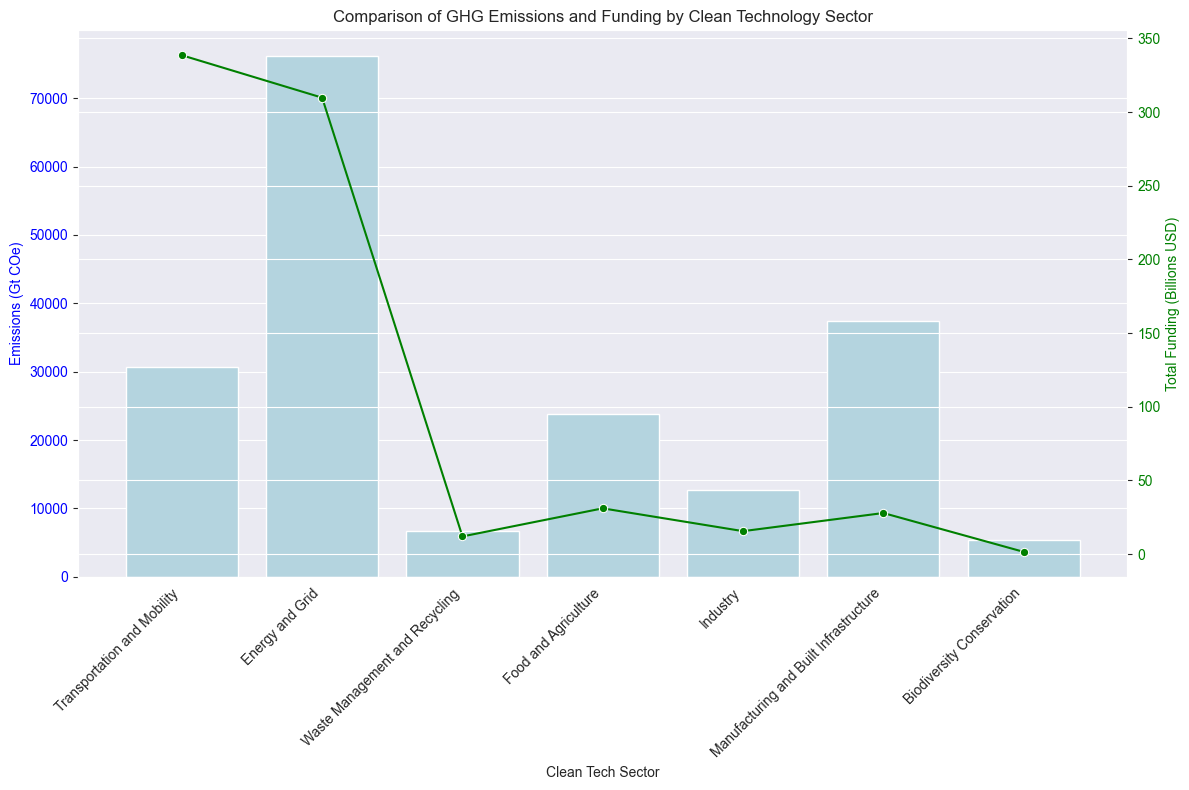

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot emissions as bars
sns.barplot(x='Clean Tech Sector', y='Emissions', data=emissions_funding_df, color='lightblue', ax=ax1)
ax1.set_ylabel('Emissions (Gt COe)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for funding
ax2 = ax1.twinx()

# Plot funding as a line
sns.lineplot(x='Clean Tech Sector', y='Total Funding (Billions USD)', data=emissions_funding_df, marker='o', color='green', ax=ax2)
ax2.set_ylabel('Total Funding (Billions USD)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Set x-axis labels and rotate them
ax1.set_xticklabels(emissions_funding_df['Clean Tech Sector'], rotation=45, ha='right')

# Set the title
plt.title('Comparison of GHG Emissions and Funding by Clean Technology Sector')

# Adjust layout
plt.tight_layout()

# Save the figure
fig_filename = os.path.join(visualizations_dir, 'emissions_vs_funding_by_sector.png')
plt.savefig(fig_filename, dpi=300, bbox_inches='tight')
print(f"Figure saved to {fig_filename}")

# Show the plot
plt.show()

Figure saved to visualizations\2024-11-14_07-52-09\emissions_vs_funding_by_sector.png


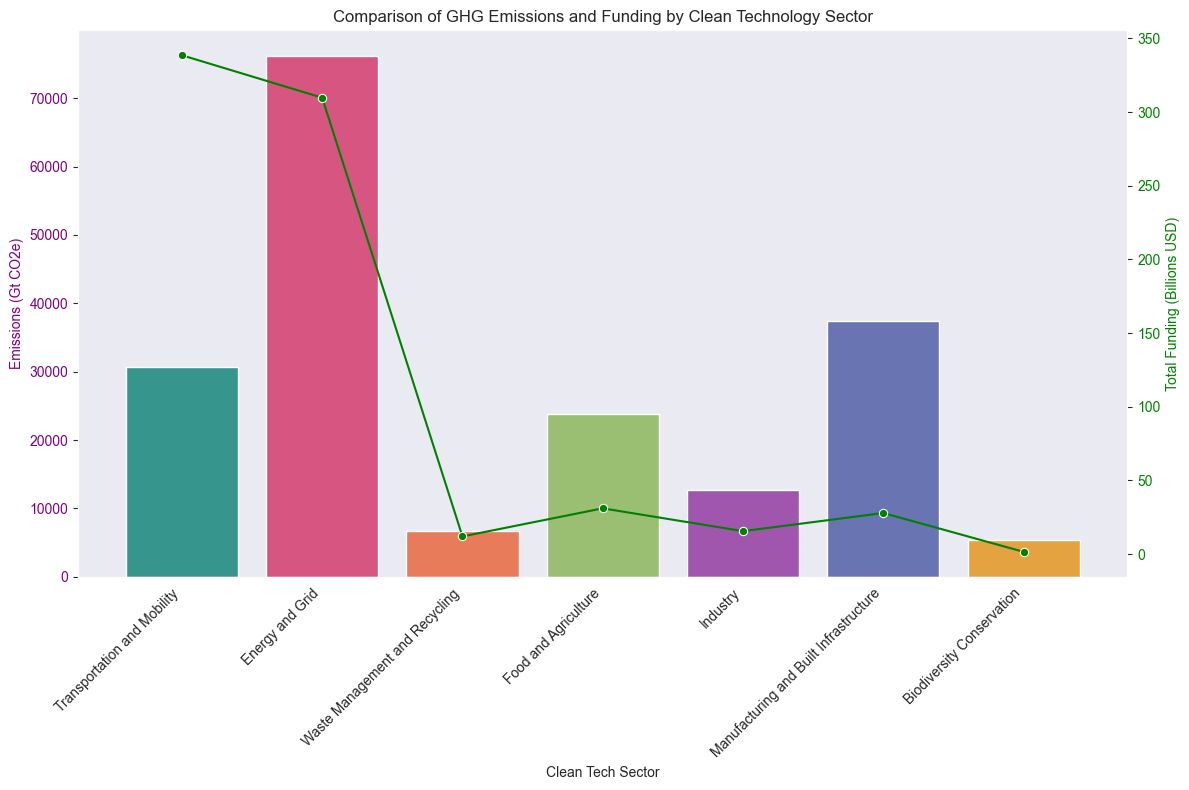

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot emissions as bars, using the assigned colors for each sector
sns.barplot(
    x='Clean Tech Sector', 
    y='Emissions', 
    data=emissions_funding_df, 
    palette=climate_tech_sector_colors,  # Use assigned colors for each sector
    ax=ax1
)
ax1.set_ylabel('Emissions (Gt CO2e)', color='purple')
ax1.tick_params(axis='y', labelcolor='purple')
ax1.grid(False)

# Create a second y-axis for funding
ax2 = ax1.twinx()

# Plot funding as a line
sns.lineplot(
    x='Clean Tech Sector', 
    y='Total Funding (Billions USD)', 
    data=emissions_funding_df, 
    marker='o', 
    color='green', 
    ax=ax2
)
ax2.set_ylabel('Total Funding (Billions USD)', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.grid(False)

# Set x-axis labels and rotate them
ax1.set_xticklabels(emissions_funding_df['Clean Tech Sector'], rotation=45, ha='right')

# Set the title
plt.title('Comparison of GHG Emissions and Funding by Clean Technology Sector')

# Adjust layout
plt.tight_layout()

# Save the figure
fig_filename = os.path.join(visualizations_dir, 'emissions_vs_funding_by_sector.png')
plt.savefig(fig_filename, dpi=300, bbox_inches='tight')
print(f"Figure saved to {fig_filename}")

# Show the plot
plt.show()

### 5.6 Identifying Underserved Sectors

Based on the analysis, we can identify sectors that are potentially underserved in terms of funding relative to their emissions impact. This information can be used to inform investors about high-impact investment opportunities.


In [53]:
# Highlight sectors with lowest funding per Gt COe
underserved_sectors = emissions_funding_df.nsmallest(3, 'Funding per Gt CO2e (USD)')

print("Potentially Underserved Sectors:")
underserved_sectors[['Clean Tech Sector', 'Emissions', 'Total Funding (Billions USD)', 'Funding per Gt CO2e (USD)']]

Potentially Underserved Sectors:


Clean Tech Sector     Emissions  \
0               Biodiversity Conservation   5389.320174   
4  Manufacturing and Built Infrastructure  37417.199973   
3                                Industry  12638.469651   

   Total Funding (Billions USD)  Funding per Gt CO2e (USD)  
0                      1.560333               2.895232e+05  
4                     27.917627               7.461175e+05  
3                     15.609877               1.235108e+06